In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode_paper/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
from itertools import product
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
plt.style.use('seaborn-v0_8-muted')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, accuracy_perumtations, 
    age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test, deconfound,
    fit_deconfound_model, 
)

In [3]:
save_figures = False

In [4]:
# TODO: 
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?

In [5]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [6]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence, cv
#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval

#exp = '2023-02-07T06:28:03.373666' # TCN exluding recs with age divergence, subject-wise cv
#exp = '2023-02-09T09:34:21.685021' # TCN exluding recs with age divergence, subject-wise fe 


#exp = '2023-02-10T23:14:51.938016'  # mixed patho and non-patho data
#exp = '2023-02-11T09:11:11.990975'  # subset non-patho, match patho and non-patho dists
#exp = '2023-02-11T09:11:23.883557'  # subset non-patho, uniform patho and non-patho dists

exp = '2023-02-15T18:59:11.767923'  # cv, l1loss
exp = '2023-02-15T18:43:26.819382'  # fe, l1loss
#exp = '2023-05-04T08:38:44.048946'  # cv, l2loss
#exp = '2023-05-08T09:22:38.974401'  # fe, l2loss  # currently re-running with longitudinals
#exp = '2023-05-09T09:15:59.256046'  # fe, l2loss  # longitudinal crashed

#exp = '2023-02-22T12:51:02.928667'


exp_dir = os.path.join(base_dir, exp)

In [7]:
configs = read_result(exp_dir, 'config')

In [8]:
assert len(configs) == 5

In [9]:
configs.iloc[0]

augment                                                                dropout
batch_size                                                                 128
data_path                    /home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...
date                                                2023-02-15T18:43:26.819382
debug                                                                        1
fast_mode                                                                    1
final_eval                                                                   1
intuitive_training_scores                                                    1
loss                                                                       mae
max_age                                                                     -1
min_age                                                                     -1
model_name                                                                 tcn
n_epochs                                            

In [10]:
assert configs['final_eval'].nunique() == 1

In [11]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed', 'final_eval']]

,model_name,target_name,valid_set_i,seed,final_eval
0,tcn,age,0,20230214,1
0,tcn,age,0,20230215,1
0,tcn,age,0,20230216,1
0,tcn,age,0,20230217,1
0,tcn,age,0,20230218,1


In [12]:
scores = read_result(exp_dir, 'score')

In [13]:
def average_scores(scores):
    scores_ = {}
    for score in scores.index.unique():
        for subset in scores.columns:
            if subset not in scores_:
                scores_[subset] = {}
            scores_[subset].update({score: scores.loc[score, subset].mean()})
    return pd.DataFrame(scores_).drop(['seed', 'valid_set_i'], axis=1)

In [14]:
average_scores(scores)

,train,eval,eval_not_normal,transition,non_pathological,pathological,transition_long,non_pathological_long,pathological_long,transition_long_clean_age,non_pathological_long_clean_age,pathological_long_clean_age,lnp,lp,lnpp,lpnp,nlnp,nlp,nlnpp,nlpnp
mae,2.676739,6.517127,13.415539,11.770793,1.337067e+01,16.250088,11.697070,1.202639e+01,15.792732,12.120994,11.815610,15.638920,10.047124,15.254722,12.192501,11.074950,15.415788,15.062218,15.681809,15.807203
mape,0.065842,0.166104,0.232763,0.407534,2.108755e+06,587487.061264,0.407996,2.386170e+06,586644.279400,0.376190,0.559343,0.377315,0.264614,0.333503,0.340080,0.298033,0.582752,0.488811,0.558147,0.565154
mdae,1.742511,5.434862,11.378739,9.664617,9.604606e+00,13.560675,9.404413,8.497187e+00,13.093110,9.613568,9.237580,12.994081,8.138520,12.749054,9.489480,9.735177,11.782431,11.640397,12.346581,12.637010
mdape,0.042046,0.136944,0.201271,0.206327,2.239139e-01,0.252980,0.201404,2.034687e-01,0.244721,0.206254,0.215884,0.244187,0.193608,0.238624,0.197763,0.217654,0.233398,0.234721,0.244347,0.250891
r2,0.938632,0.729647,0.091834,0.301654,1.705781e-01,-0.077597,0.309442,2.445779e-01,-0.066213,0.230802,0.159408,-0.147724,0.325734,-0.141933,0.173828,0.378128,-0.000566,0.053113,-0.065933,-0.058529


In [15]:
histories = read_result(exp_dir, 'history')

In [16]:
loss = configs['loss'].unique()
assert len(loss) == 1
loss = loss[0]
if loss == 'mae':
    loss_label = 'L1 Loss' 
elif loss == 'mse':
    loss_label = 'L2 Loss'
else:
    raise NotImplementedError

In [17]:
fe = (configs['final_eval'] == '1').all()

In [18]:
cv_or_fe = 'fe' if fe else 'cv'

In [19]:
fe, cv_or_fe

(True, 'fe')

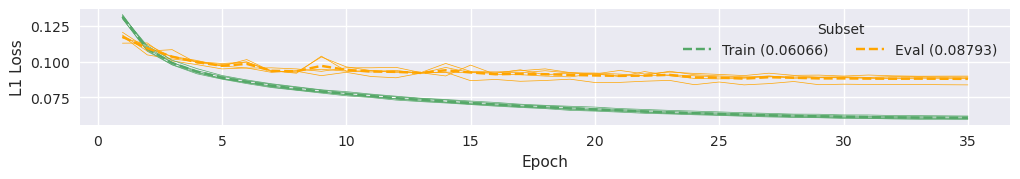

In [20]:
if fe:
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], loss_label, 'Eval')
    #ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
    if save_figures:
        save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_curves.png')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], loss_label)
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        #ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_curves_{n1}')

In [21]:
def prepare_preds(g1, sex, min_age, max_age, fe):
    g1 = g1[g1.gender==sex] if sex is not None else g1
    max_age = g1.age.max() if max_age is None else max_age
    min_age = g1.age.min() if min_age is None else min_age
    g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
    # if fe, average over different seeds; if cv, basically don't average
    grouper = ['subset', 'index'] if fe else ['subset', 'subject', 'session', 'segment', 'seed']
    # after averaging, seed variable does not make sense anymore, so drop it
    g1 = g1.reset_index().groupby(grouper, as_index=False).mean(numeric_only=True)#.drop(['seed'], axis=1)
    g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
    return g1


def add_deconfounded_predictions(g1, coefs):
    if coefs is None:
        coefs = fit_deconfound_model(
            g1[g1.pathological == False].y_true, 
            g1[g1.pathological == False].y_pred, 
        )
    g1['y_pred_confounded'] = g1.y_pred
    for kind, coef in coefs.items():
        #g1[f'y_pred_deconfounded_{kind}'] = g1.y_pred - [coefs_to_func(coef, y) for y in g1.y_true]  # y
        g1[f'y_pred_deconfounded_{kind}'] = g1.y_pred - [coefs_to_func(coef, y) for y in g1.y_pred]
    return g1, coefs


# from list of coeffs generate a string representing the function formula
def coefs_to_func_str(coefs):
    s = ''.join([f' + {coef:.1e}'+'x'*i if coef >= 0 else f'{coef:.1e}'+'x'*i for i, coef in enumerate(coefs[::-1])][::-1])
    if s.startswith('+'):
        s = s[2:]
    return 'f(x) = ' + s


# from list of coeffs compute the result of the represented function
def coefs_to_func(coefs, x):
    # coefs from high to low order
    return sum([coef*x**i for i, coef in enumerate(coefs[::-1])][::-1])


# plot bias of model that is being fit: ytrue to ypred-ytrue
def plot_true_age_vs_gap(y_true, y_pred, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.scatter(y_true, y_pred-y_true, facecolor='b', edgecolor='k', alpha=.5)
    ax.plot([0,100],[0,0], c='k', linewidth=1)
    ax.set_xlabel('Chronological Age [years]')
    ax.set_ylabel('Brain Age Gap\n[years]')
    ax.legend();
    ylim = np.max(np.abs(ax.get_ylim()))
    ax.set_ylim(-ylim, ylim)
    return ax


def plot_bias_model(coeffs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    for (kind, coefs), style in zip(coeffs.items(), ['-', ':']):
        ax.plot(
            [coefs_to_func(coefs, p) for p in np.arange(100)], 
            label=coefs_to_func_str(coefs), linewidth=2,
            linestyle=style, c='cyan',
        )
    ax.legend(loc='lower left')
    return ax


def plot_model_bias(y_true, y_pred, coeffs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax = plot_true_age_vs_gap(preds.y_true, preds.y_pred, ax=ax)
    ax = plot_bias_model(coeffs, ax)
    return ax

In [22]:
preds = read_result(exp_dir, 'preds')
preds.shape

(1215, 20)

In [23]:
age_limits = [(None, None)]# [(None, 30), (30, 60), (60, None)]  #[(None, 30), (30, 60), (60, None)]#
sexes = [None]#['F', 'M'] #[None]#

In [24]:
preds = prepare_preds(preds, sex=None, min_age=None, max_age=None, fe=fe)
preds.shape

(219, 17)

In [25]:
def accs_for_patho_from_thresh(series, pathological):
    assert len(series) == len(pathological)
    accs = []
    for i in range(len(series)):
        acc = balanced_accuracy_score(pathological, i*[0]+(len(series)-i)*[1])
        accs.append(acc*100)
    return accs


def plot_accs_for_patho_from_thresh(dataframe, accs, ax=None):
    df = dataframe.copy()
    df.pathological = df.pathological == 1
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 1.5))
    #ax2 = ax.twinx()
    #ax2 = sns.histplot(data=tmp, x='y_true', hue='pathological', ax=ax2, binwidth=1, palette={0: 'b', 1: 'r'})
    ax.plot(df.y_true, accs, c='k')
    #ax.plot(data=df, x='y_true', y=accs, c='k', ax=ax, errorbar=None)#, hue='pathological', palette={0: 'b', 1: 'r'}, alpha=.5)
    #ax.plot([0, 100], [50, 50], c='k', linestyle='--')
    #ax.axvline(tmp.y_true.iloc[np.array(accs).argmax()], c='cyan', linewidth=1)
    ax.set_ylabel('Balanced Accuracy\n[%]')
    return ax

In [26]:
from decode_tueg import plot_violin_new, accuracy_perumtations, get_hist_perm_test_grid

In [28]:
n_repetitions = 100000
save_figures = False

acc based on cv age thresh (48.25) 66.54%
acc based on fe age thresh (62.00) 67.13%
p=1.00E-05


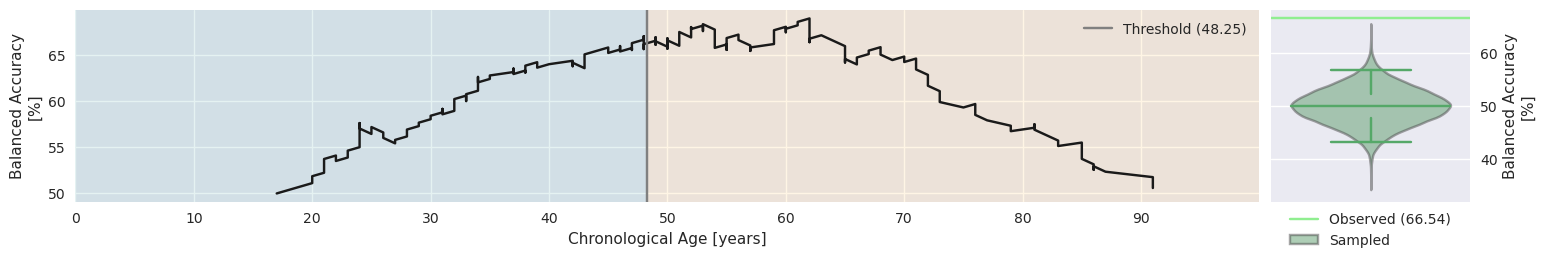

In [29]:
ax0, ax1 = get_hist_perm_test_grid()
accs = accs_for_patho_from_thresh(
    preds.sort_values('y_true').y_true,
    preds.sort_values('y_true').pathological,
)
ax = plot_accs_for_patho_from_thresh(
    preds.sort_values('y_true'),
    accs,
    ax0,
)
ax.set_xlim([0, 100])
if not fe:
    thresh = preds.sort_values('y_true').y_true.iloc[np.argmax(accs)]
    #thresh = 48.25000096857548
    #print(f'cv age thresh {thresh:.2f}')
    acc = 100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)
    print(f'acc based on cv age thresh ({thresh:.2f}) {acc:.2f}%')    
else:
    thresh = 48.25000096857548
    acc = 100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)
    print(f'acc based on cv age thresh ({thresh:.2f}) {acc:.2f}%')    
    optimal_thresh = preds.sort_values('y_true').y_true.iloc[np.argmax(accs)]
    print(f'acc based on fe age thresh ({optimal_thresh:.2f}) {(100*balanced_accuracy_score(preds.pathological, preds.y_true > optimal_thresh)):.2f}%')    
    #print(f'acc based on cv age thresh {(100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)):.2f}%')
ax.axvline(thresh, c='grey', label=f'Threshold ({thresh:.2f})')
ax.set_xlabel('Chronological Age [years]')

ax.axvspan(0, thresh, facecolor='teal', alpha=.1)
ax.axvspan(thresh, 100, facecolor='orange', alpha=.1)

observed, sampled = accuracy_perumtations(
    preds,
    n_repetitions=n_repetitions,
    indicator='age',
)
plot_violin_new(
    acc,
    sampled,
    50,
    ax1,
)
ax1.set_ylabel('Balanced Accuracy\n[%]')

ticks = np.linspace(0,100,11,dtype=int)[:-1]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.legend()

#ax.axvline(preds[preds.pathological==1].y_true.mean(), c='magenta')
#ax.axvline(preds[preds.pathological==0].y_true.mean(), c='teal')
#ax.legend(title='Pathological')
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_thresh')

In [30]:
preds['gap'] = preds.y_pred - preds.y_true
accs = accs_for_patho_from_thresh(
    preds.sort_values('gap').gap,
    preds.sort_values('gap').pathological,
)

In [31]:
# TODO: fix
ax = plot_accs_for_patho_from_thresh(
    preds.sort_values('gap').gap,
    accs,
)
thresh = preds.sort_values('gap').gap.iloc[np.argmax(np.abs([100-a for a in accs]))]
ax.axvline(thresh, c='grey')
ax.set_xlabel('Decoded Age – Chronological Age [years]')

AttributeError: 'Series' object has no attribute 'pathological'

In [32]:
# exp = '2023-02-15T18:59:11.767923'  # cv, l1loss
# exp = '2023-02-15T18:43:26.819382'  # fe, l1loss
cv_exp_dir = '/home/jovyan/experiments/2023-02-15T18:59:11.767923'
cv_seed = '20230214'

In [33]:
if not fe:
    assert configs.seed.nunique() == 1
    cv_seed = configs.seed.unique()[0]
    cv_exp_dir = exp_dir
cv_dir = os.path.join(cv_exp_dir, cv_seed)

In [34]:
# if cv_dir is None
fn = 'bias_models.json'
if not fe:
    preds, coeffs = add_deconfounded_predictions(preds, coefs=None)
    p = os.path.join(cv_dir, fn)
    print(f"duming model coefficients to {p}")
    json.dump(coeffs, open(p, 'w'))
else:
    p = os.path.join(cv_dir, fn)
    print(f"loading model coefficients from {p}")
    coeffs = json.load(open(p, 'r'))
    preds, coeffs = add_deconfounded_predictions(preds, coefs=coeffs)
coeffs

loading model coefficients from /home/jovyan/experiments/2023-02-15T18:59:11.767923/20230214/bias_models.json


{'linear': [-0.36310181197536046, 15.374280445171014],
 'quadratic': [-0.004431773520303435, 0.05752921309654997, 6.582235069495847]}

In [35]:
def plot_biased_vs_corrected_gap_to_age_with_dists(y_true, y_pred, y_pred_deconfounded, coeffs, age_hist=True, binwidth=1):
    fig, ax_arr = plt.subplots(3, 2, figsize=(12,5), width_ratios=[.9, .1])
    fig.subplots_adjust(hspace=.1)
    fig.subplots_adjust(wspace=.025)

    if not age_hist:
        ax = ax_arr[0,1]
        ax.remove()

    ax = ax_arr[1,0]
    ax = plot_model_bias(
        y_true, 
        y_pred,
        coeffs,
        ax=ax,
    )
    ax.set_xlabel('')
    ax.set_xticklabels([])
    lims = ax.get_ylim()

    ax = ax_arr[1,1]
    sns.histplot(y=y_pred-y_true, ax=ax, binwidth=binwidth, kde=True)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.yaxis.tick_right()
    #ax.set_ylim([0,100])
    ax.set_ylabel("")
    ax.set_ylim(lims)

    ax = ax_arr[2,0]
    ax = plot_true_age_vs_gap(y_true, y_pred_deconfounded, ax=ax)
    ax.set_ylabel('Corrected\nBrain Age Gap\n[years]');
    ticks = ax.get_xticks()
    lim = ax.get_xlim()
    lims = ax.get_ylim()

    ax = ax_arr[2,1]
    sns.histplot(y=y_pred_deconfounded-y_true, ax=ax, binwidth=binwidth, kde=True)
    ax.yaxis.tick_right()
    #ax.set_ylim([0,100])
    ax.set_ylabel("")
    ax.set_ylim(lims)

    if age_hist:
        ax = ax_arr[0,0]
        sns.histplot(y_true, ax=ax, binwidth=binwidth, kde=True)
        ax.set_xlabel('')
        ax.set_xticklabels([]);
        ax.set_xticks(ticks)
        ax.set_xlim(lim)
    else:
        ax = ax_arr[0,0]
        ax.remove()
    return ax_arr

In [36]:
def plot_biased_vs_corrected_gap_to_age(y_true, y_pred, y_pred_deconfounded, coeffs):
    fig, ax_arr = plt.subplots(2, 1, figsize=(12,4), sharex=True)
    fig.subplots_adjust(hspace=.1)
    ax = plot_model_bias(
        y_true, 
        y_pred,
        coeffs,
        ax=ax_arr[0],
    )
    ax.set_xlabel('')
    ax = plot_true_age_vs_gap(y_true, y_pred_deconfounded, ax=ax_arr[1])
    ax.set_ylabel('Corrected\nBrain Age Gap\n[years]');
    return ax

In [37]:
fit_deconfound_model(preds[preds.pathological==0].y_true, preds[preds.pathological==0].y_pred)

{'linear': (-0.3290777344963141, 13.598413676371154),
 'quadratic': (-0.0017585743367344745,
  -0.16745359881063412,
  10.335490810065528)}

In [38]:
detrend = 'quadratic'

In [39]:
save_figures=False

In [40]:
# hardcode function in nice
def coefs_to_func_str(_):
    return r'$f(x) = -4.43 * 10^{-3}x^{2}  + 5.75 * 10^{-2}x + 6.58$'

In [41]:
save_figures=False

In [42]:
split = False

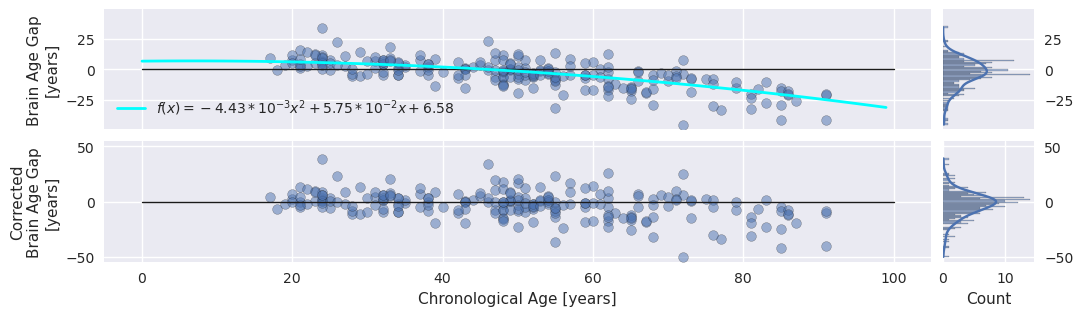

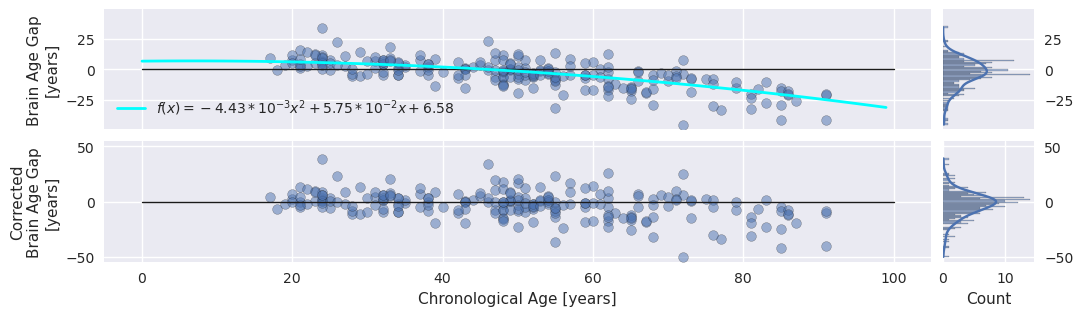

In [43]:
for i in [2, 1]:
    # plot_biased_vs_corrected_gap_to_age(preds.y_true, preds.y_pred, preds.y_pred_deconfounded_quadratic, coeffs)
    ax_arr = plot_biased_vs_corrected_gap_to_age_with_dists(
        preds.y_true, preds.y_pred, 
        preds[f'y_pred_deconfounded_{detrend}'], {detrend: coeffs[detrend]}, 
        age_hist=False)
    if save_figures:
        save_fig(ax_arr[-1,-1].get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_bias_model')

    if split:
        # only keep upper / lower part of plot
        ax_arr[i][0].remove()
        ax_arr[i][1].remove()
        ax_arr[1, 0].set_xlabel('Chronological Age [years]')
        if save_figures:
            save_fig(ax_arr[i, 0].get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_bias_model')


In [44]:
preds['y_pred'] = preds[f'y_pred_deconfounded_{detrend}']

In [45]:
from decode_tueg import find_threshs

In [46]:
fn = 'proxy_thresholds.json'
if not fe:
    (t_low, t_high) = find_threshs(preds)
    threshs = {'t_low': t_low, 't_high': t_high}
    p = os.path.join(cv_dir, fn)
    print(f"duming thresholds to {p}")
    json.dump(threshs, open(p, 'w'))
else:
    p = os.path.join(cv_dir, fn)
    print(f"loading thresholds from {p}")
    threshs = json.load(open(p, 'r'))
    t_low = threshs['t_low']
    t_high = threshs['t_high']  
t_low, t_high

loading thresholds from /home/jovyan/experiments/2023-02-15T18:59:11.767923/20230214/proxy_thresholds.json


(-9.219088895674346, 8.589625318405407)

In [47]:
bin_width = 2
n_repetitions = 100

In [48]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [49]:
from decode_tueg import plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test

In [50]:
from sklearn.metrics import r2_score, auc, roc_auc_score

In [51]:
def get_scores(preds):
    for pathological in [0, 1]:
        for deconfound in ['y_pred_confounded', 'y_pred_deconfounded_linear', 'y_pred_deconfounded_quadratic']:
            mae = mean_absolute_error(
                preds[preds.pathological==pathological].y_true,
                preds[preds.pathological==pathological][deconfound],
            )
            print(pathological, deconfound, 'mae', mae)
            r2 = r2_score(
                preds[preds.pathological==pathological].y_true,
                preds[preds.pathological==pathological][deconfound],
            )
            print(pathological, deconfound, 'r2', r2)
            print()

In [52]:
get_scores(preds)

0 y_pred_confounded mae 6.475429911260951
0 y_pred_confounded r2 0.7360309849351269

0 y_pred_deconfounded_linear mae 6.715772451107209
0 y_pred_deconfounded_linear r2 0.7064184678774831

0 y_pred_deconfounded_quadratic mae 6.60445472036638
0 y_pred_deconfounded_quadratic r2 0.7096574944386915

1 y_pred_confounded mae 13.307039500124315
1 y_pred_confounded r2 0.11324894066455349

1 y_pred_deconfounded_linear mae 12.614352418126181
1 y_pred_deconfounded_linear r2 0.11928884404284867

1 y_pred_deconfounded_quadratic mae 12.820447560321453
1 y_pred_deconfounded_quadratic r2 0.08936785812430659



In [53]:
n_repetitions = 100000
save_figures = False

p=1.63E-02
p=1.32E-03


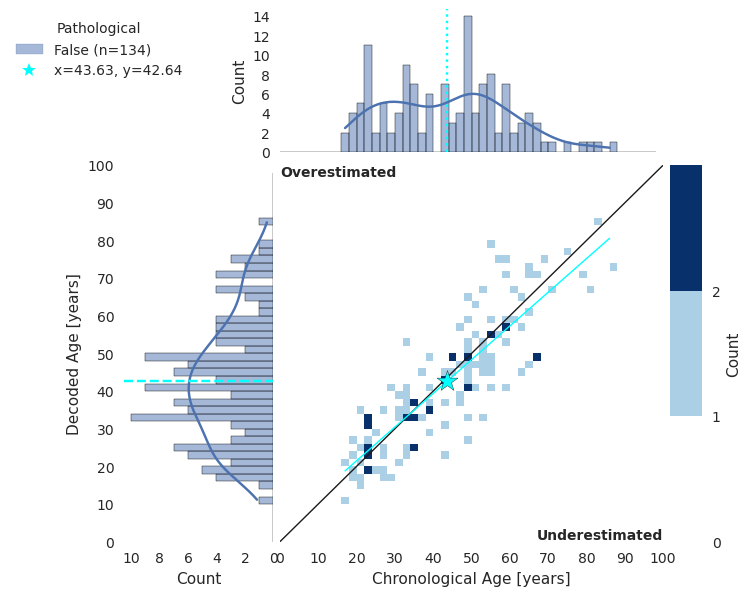

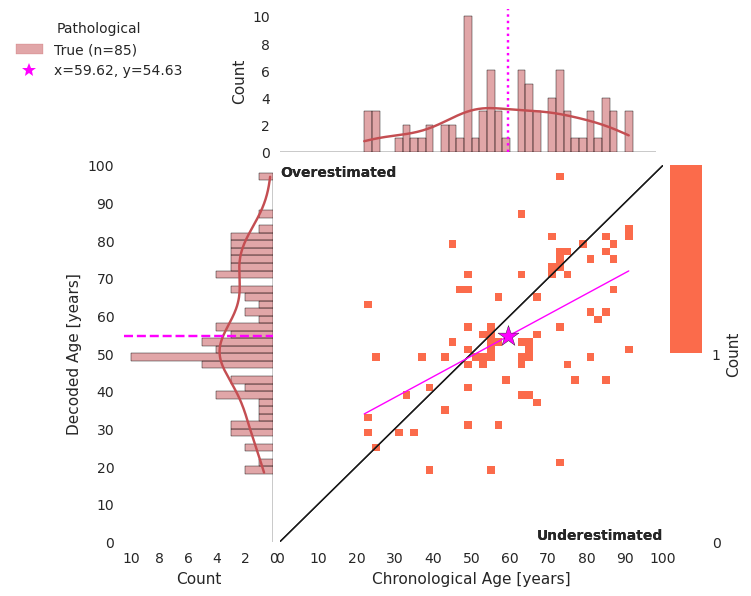

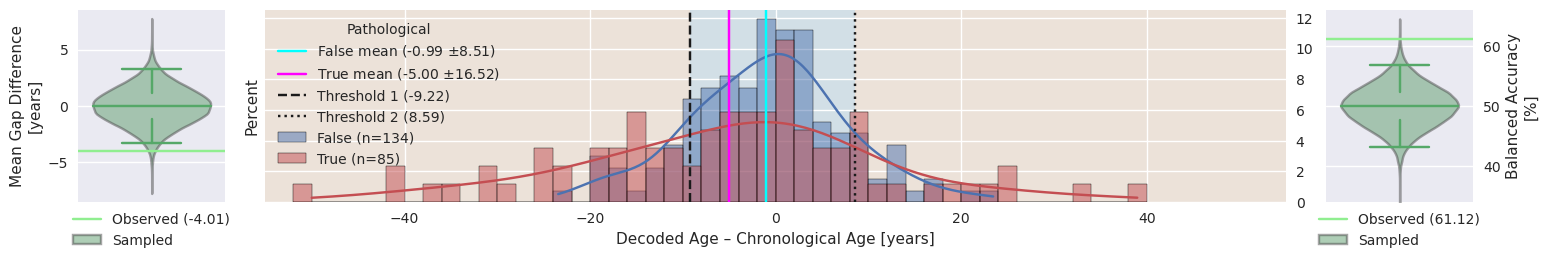

In [54]:
#preds['y_pred'] = preds[f'y_pred_deconfounded_{detrend}'] if not fe else preds['y_pred_confounded']
#preds['y_pred'] = preds[f'y_pred_confounded']
ax = plot_heatmaps(preds[preds.pathological==0], bin_width)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_np_age_heatmap')
ax = plot_heatmaps(preds[preds.pathological==1], bin_width)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_p_age_heatmap')
"""
# np and p together
ax = plot_heatmaps(preds, bin_width)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_heatmap')
"""
"""ax = plot_age_gap_hist_and_permutation_test(preds, bin_width, n_repetitions)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_histogram')
ax = plot_age_gap_hist_with_thresh_and_permutation_test(
    preds, t_low, t_high, bin_width, n_repetitions,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_proxy')
"""
ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
    preds, t_low, t_high, bin_width, n_repetitions,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_hist_and_proxy')


In [55]:
get_scores(preds)

0 y_pred_confounded mae 6.475429911260951
0 y_pred_confounded r2 0.7360309849351269

0 y_pred_deconfounded_linear mae 6.715772451107209
0 y_pred_deconfounded_linear r2 0.7064184678774831

0 y_pred_deconfounded_quadratic mae 6.60445472036638
0 y_pred_deconfounded_quadratic r2 0.7096574944386915

1 y_pred_confounded mae 13.307039500124315
1 y_pred_confounded r2 0.11324894066455349

1 y_pred_deconfounded_linear mae 12.614352418126181
1 y_pred_deconfounded_linear r2 0.11928884404284867

1 y_pred_deconfounded_quadratic mae 12.820447560321453
1 y_pred_deconfounded_quadratic r2 0.08936785812430659



In [56]:
from scipy.stats import ttest_rel, ttest_1samp, kstest, mannwhitneyu

In [57]:
for subset, g in preds.groupby('subset'):
    print(subset, ttest_rel(g.y_true, g.y_pred_deconfounded_quadratic).pvalue)
    print(subset, kstest((g.y_true-g.y_true.mean())/g.y_true.std(), cdf='norm').pvalue)
    print(subset, kstest((g.y_pred_deconfounded_quadratic-g.y_pred_deconfounded_quadratic.mean())/g.y_pred_deconfounded_quadratic.std(), cdf='norm').pvalue)    
    print(subset, ttest_rel((g.y_true-g.y_true.mean())/g.y_true.std(), (g.y_pred_deconfounded_quadratic-g.y_pred_deconfounded_quadratic.mean())/g.y_pred_deconfounded_quadratic.std()).pvalue)
    print()

eval 0.17969346011938123
eval 0.182359393956575
eval 0.7679215988819186
eval 0.9999999999999966

eval_rest 0.006559743272154838
eval_rest 0.8473819265153112
eval_rest 0.5292138273103995
eval_rest 0.9999999999999986



In [58]:
for pathological in [0, 1]:
    for deconfound in ['y_pred_confounded', 'y_pred_deconfounded_linear', 'y_pred_deconfounded_quadratic']:
        mae = mean_absolute_error(
            preds[preds.pathological==pathological].y_true, 
            preds[preds.pathological==pathological][deconfound],
        )
        print(pathological, deconfound, 'mae', mae)
        r2 = r2_score(
            preds[preds.pathological==pathological].y_true, 
            preds[preds.pathological==pathological][deconfound],
        )
        print(pathological, deconfound, 'r2', r2)
        print()

0 y_pred_confounded mae 6.475429911260951
0 y_pred_confounded r2 0.7360309849351269

0 y_pred_deconfounded_linear mae 6.715772451107209
0 y_pred_deconfounded_linear r2 0.7064184678774831

0 y_pred_deconfounded_quadratic mae 6.60445472036638
0 y_pred_deconfounded_quadratic r2 0.7096574944386915

1 y_pred_confounded mae 13.307039500124315
1 y_pred_confounded r2 0.11324894066455349

1 y_pred_deconfounded_linear mae 12.614352418126181
1 y_pred_deconfounded_linear r2 0.11928884404284867

1 y_pred_deconfounded_quadratic mae 12.820447560321453
1 y_pred_deconfounded_quadratic r2 0.08936785812430659



In [59]:
# TODO: compute r2 score on TUAB NP / P in CV and FE

In [60]:
p = 0

In [61]:
mean_absolute_error(
    preds[preds.pathological==p].y_pred_deconfounded_quadratic, 
    preds[preds.pathological==p].y_true,
)

6.60445472036638

In [62]:
r2_score(
    preds[preds.pathological==p].y_pred_deconfounded_quadratic, 
    preds[preds.pathological==p].y_true,
)

0.7302474950313624

In [63]:
p = 1

In [64]:
mean_absolute_error(
    preds[preds.pathological==p].y_pred_deconfounded_quadratic,
    preds[preds.pathological==p].y_true,
)

12.820447560321453

In [65]:
r2_score(
    preds[preds.pathological==p].y_pred_deconfounded_quadratic,
    preds[preds.pathological==p].y_true,
)

0.02501035347748215

In [66]:
preds.subject.nunique()

216

In [67]:
preds.shape

(219, 21)

# FE analysis

In [68]:
import re

import mne

from decode_tueg import (
    deconfound, plot_age_gap_hist_and_permutation_test, 
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test,
    mean_abs_running_diff_of_mean_corrected_gaps, _reject_derivating_ages,
    plot_mean_abs_running_diff_of_mean_corrected_gaps,
)

In [69]:
from decode_tueg import age_pyramid

In [70]:
def counts(preds):
    rec_preds = preds.copy()
    print(f'{len(rec_preds)} recs of {rec_preds.subject.nunique()} subjects')
    # TODO: don't use seed here
    for seed, group in rec_preds.groupby('seed'):
        break
    print(f'per seed {len(group)} recs of {group.subject.nunique()} subjects')
    print(f"thereof female {group.groupby('subject').head(1).gender.value_counts()}")

In [71]:
save_figures = False

In [72]:
ylims = {'lnp': 40, 'lp': 100, 'lnpp': 20, 'lpnp': 10}

/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230216/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230218/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230216/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230218/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_

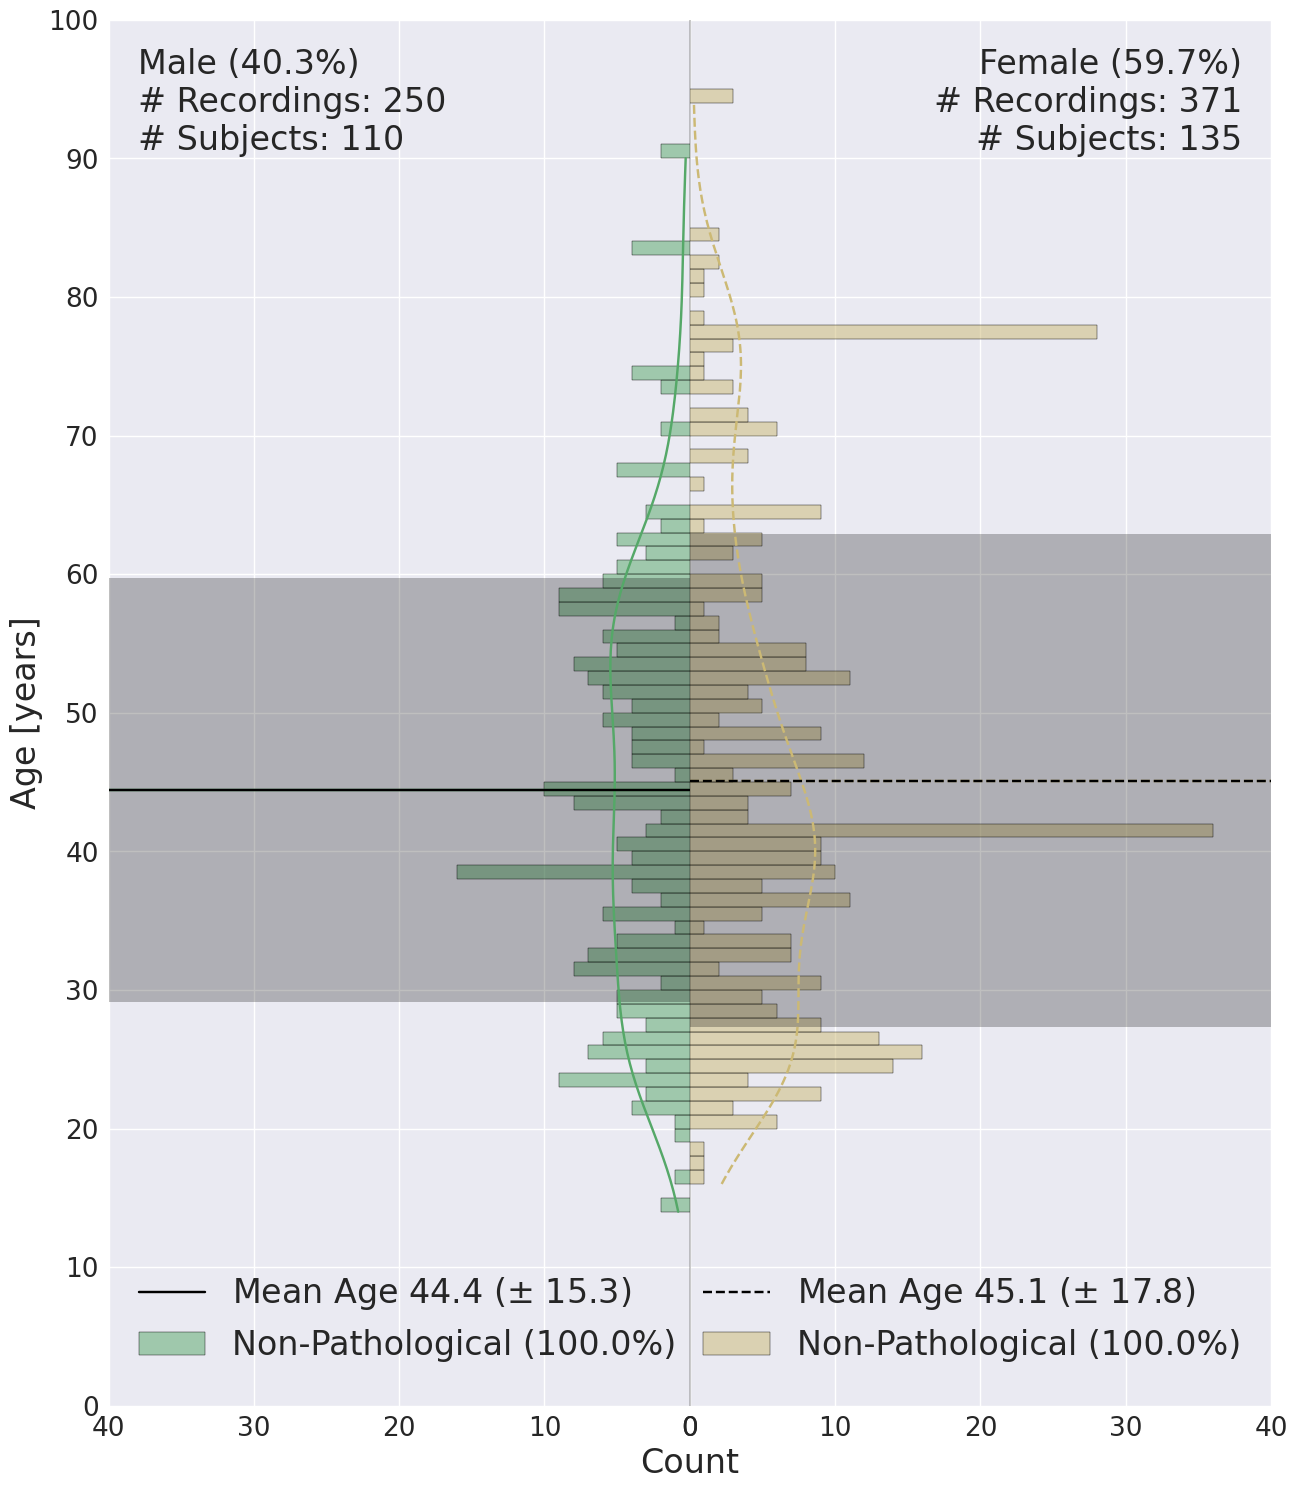

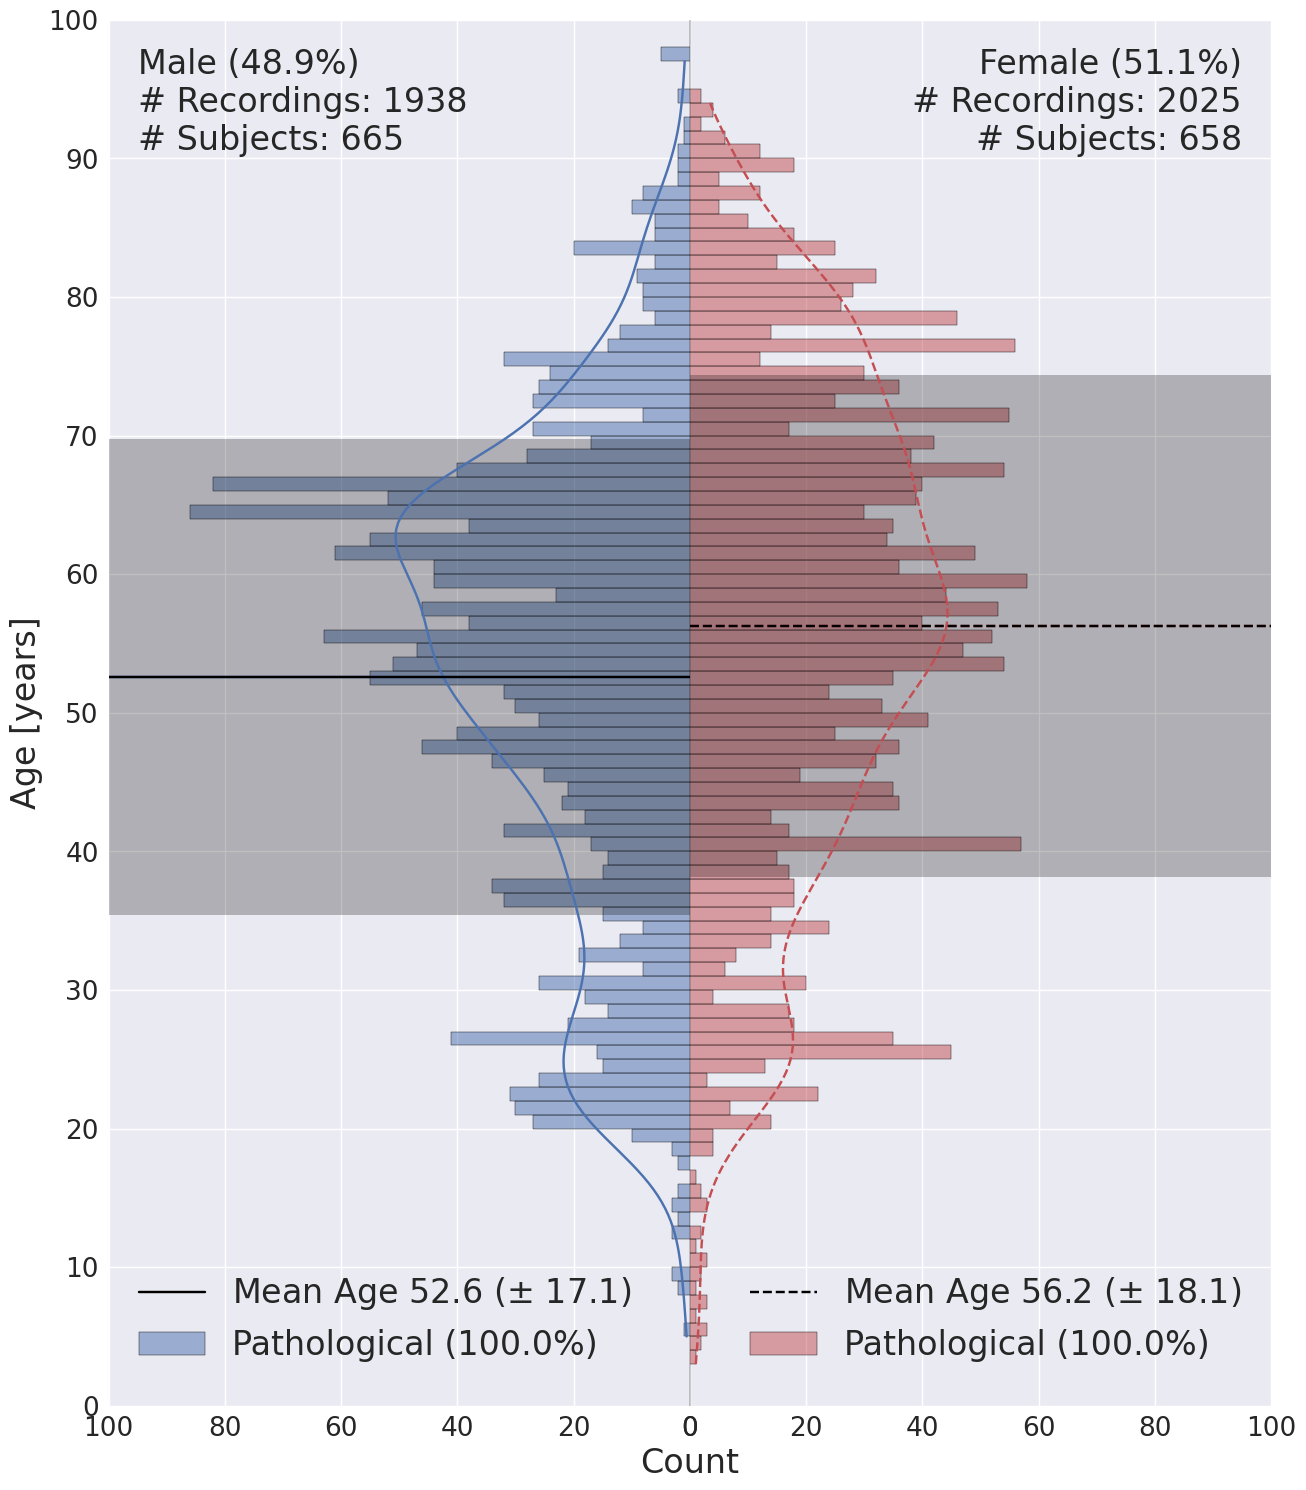

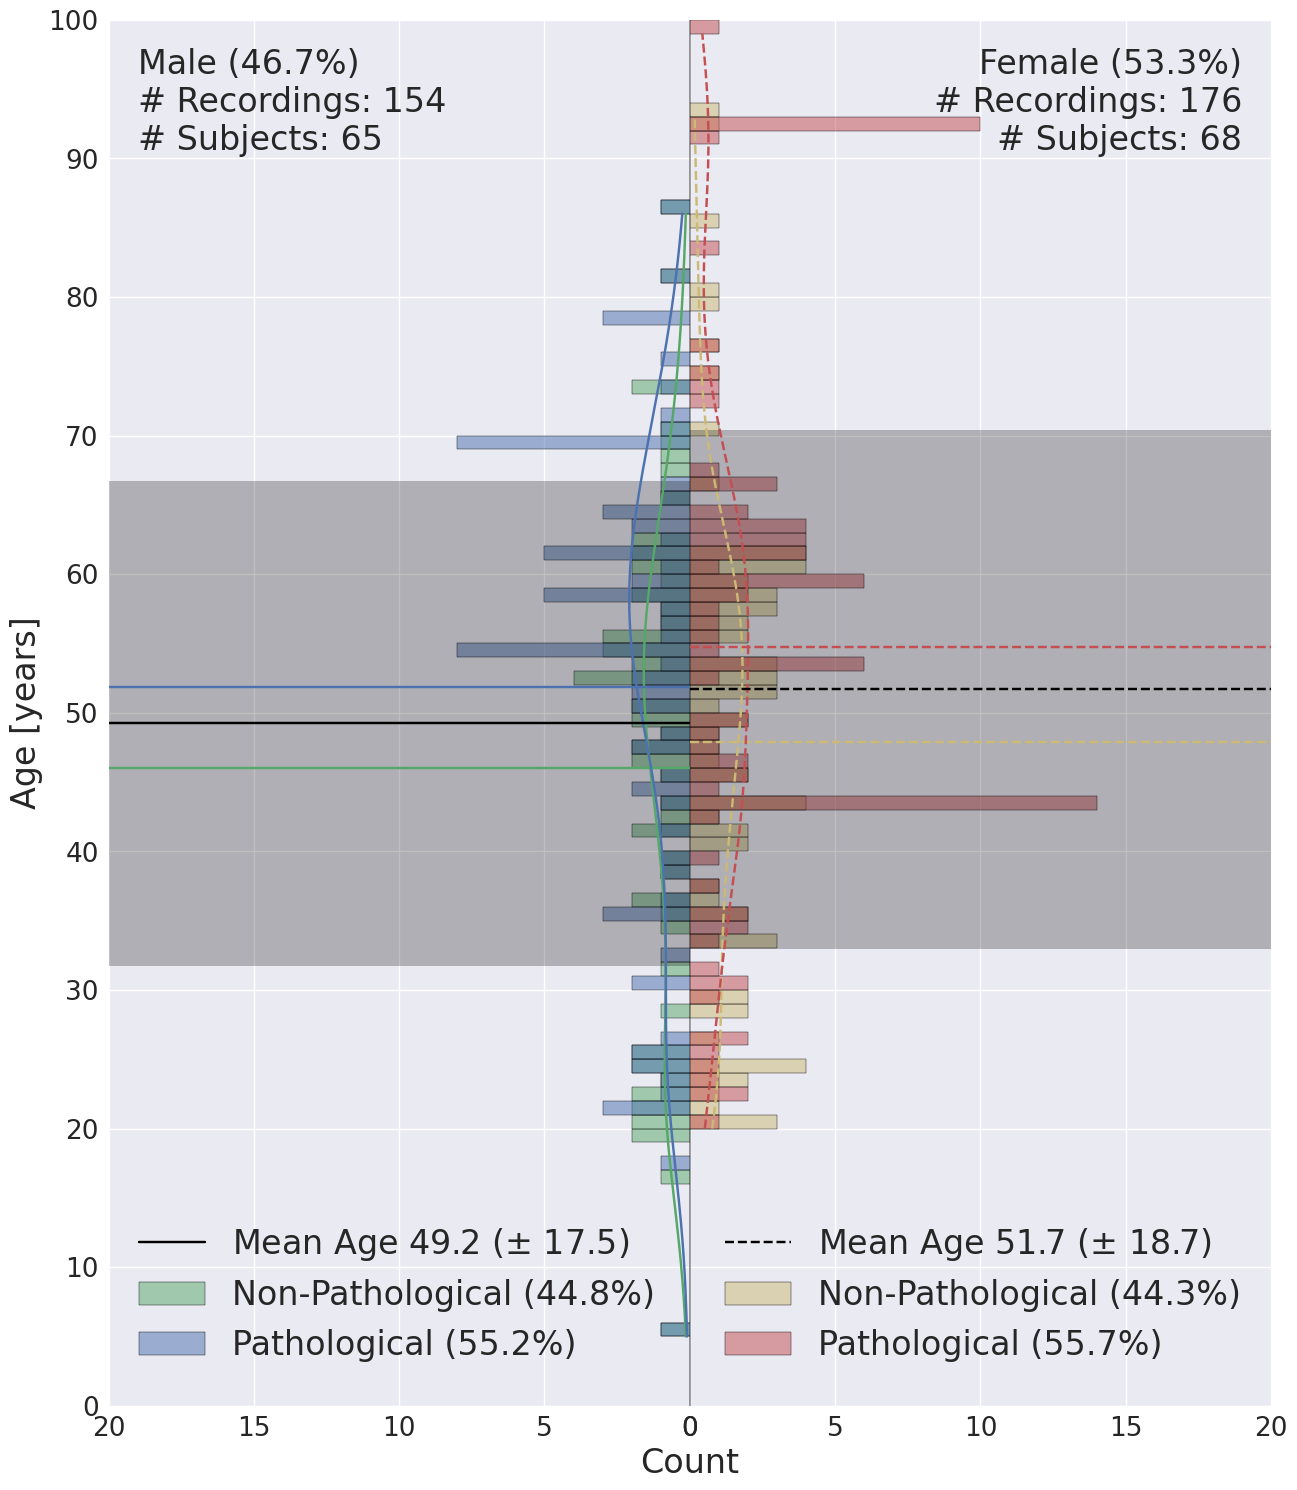

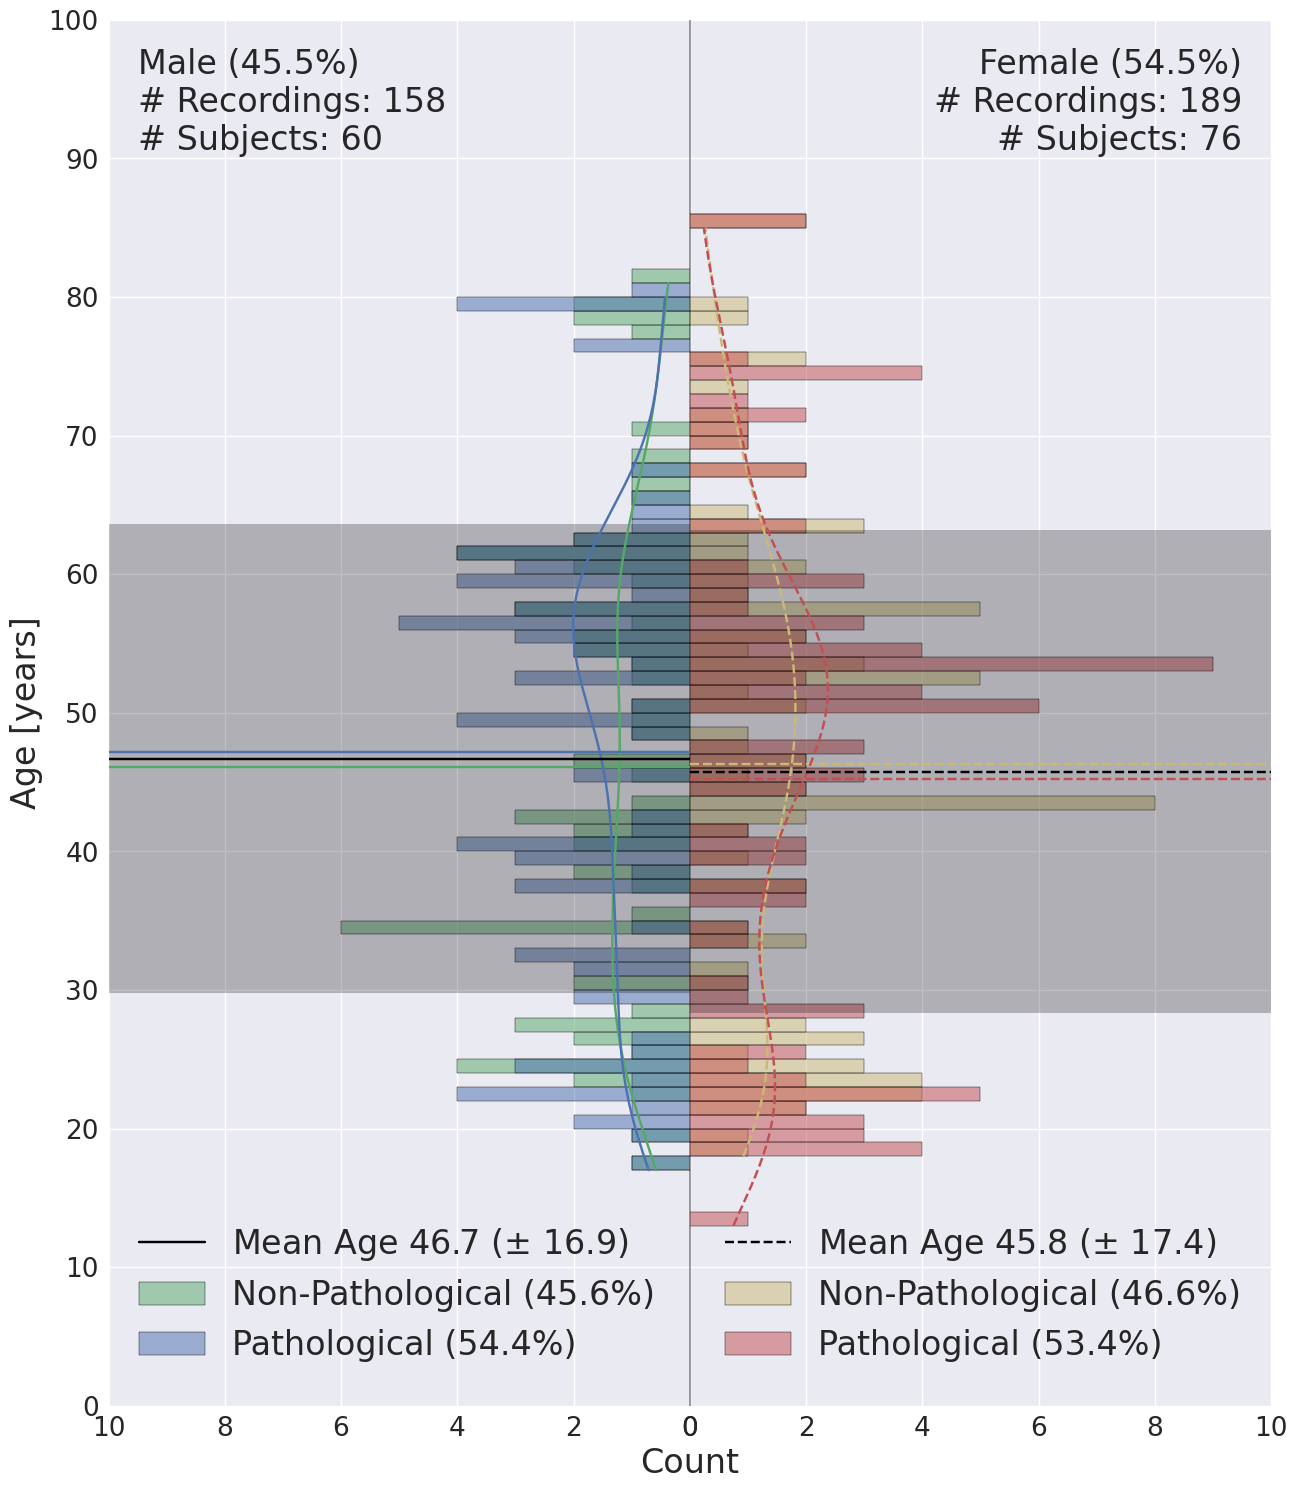

In [73]:
for ds_name in ['lnp', 'lp', 'lnpp', 'lpnp']:
    preds = read_result(exp_dir, f'{ds_name}')
    preds.replace({'M': 0, 'F': 1}, inplace=True)
    for seed, group in preds.groupby('seed'):
        break
    ax_arr = age_pyramid(group, f'eval_{ds_name}', ylim=ylims[ds_name], show_title=False)
    if save_figures:
        save_fig(ax_arr[0].get_figure(), '/home/jovyan/figures/', f'{ds_name}_age_pyramid')

In [74]:
def average_fe_runs(preds):
    preds = preds.reset_index().groupby(['dataset', 'subset', 'index'], as_index=False).mean(numeric_only=True)
    return preds

In [75]:
bin_size = 2
n_repetitions = 100000
save_figures = False

In [76]:
min_mins = 15
clean_age = True
plot = True
subset_wise = True

In [77]:
assert min_mins == 15
#assert clean_age

In [165]:
exp_dir

'/home/jovyan/experiments/2023-02-15T18:43:26.819382'

/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230216/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230218/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds/train_end_lnp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230217/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230216/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230218/0/preds/train_end_lp_preds.csv
/home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds/train_end_lp_preds.csv
(22920, 26)
(22920, 29)
(4584, 25)
(1566, 25)
lnp mae 9.27
lnp dummy mae 12

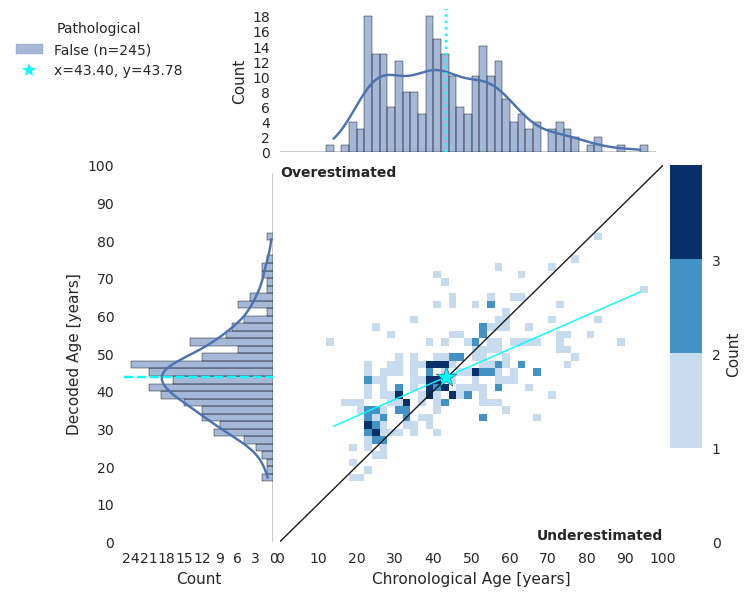

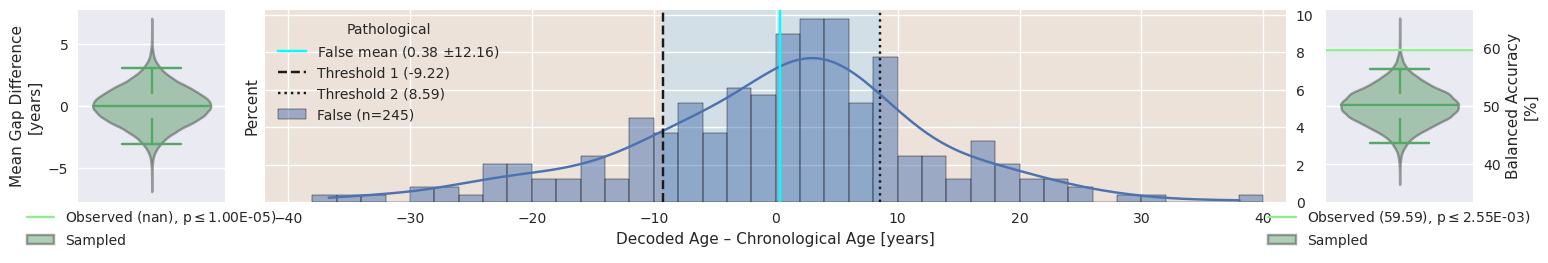

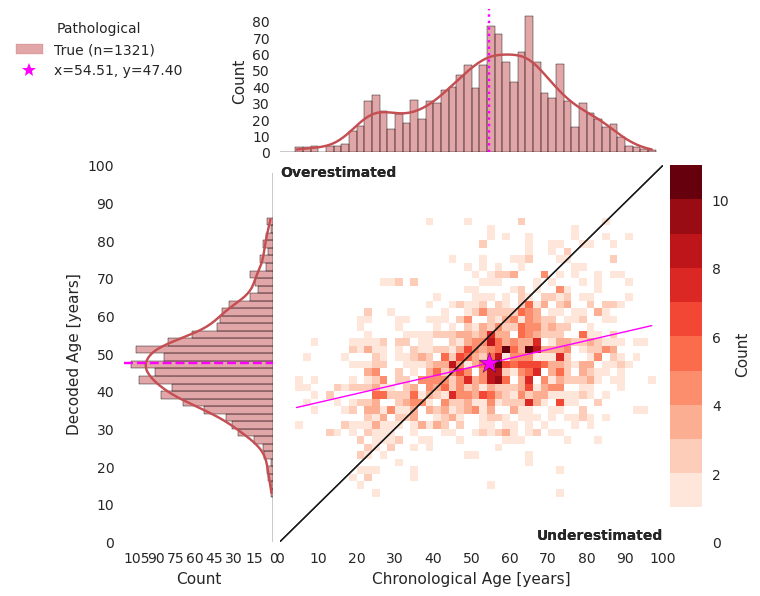

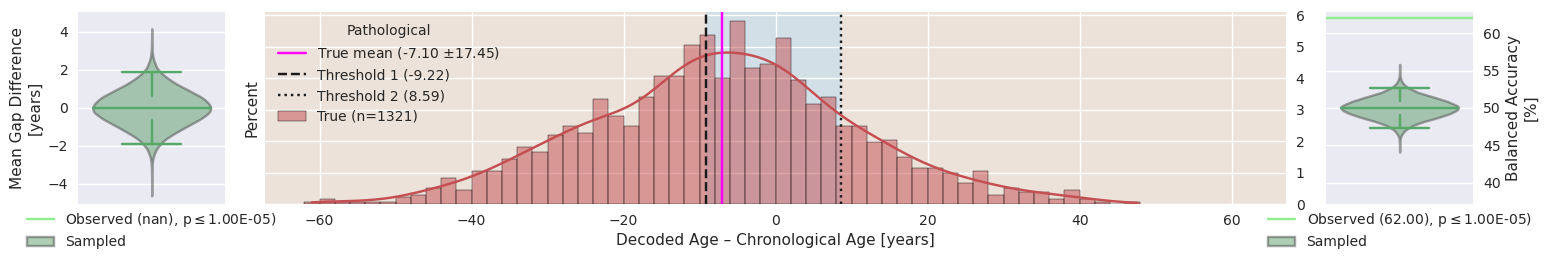

In [213]:
for ds_name in ['lnp']:  # lnpp / lnp
    preds = read_result(exp_dir, f'{ds_name}')
    if ds_name in ['lnp', 'nlnp']:
        if ds_name == 'lnp':
            preds_p = read_result(exp_dir, 'lp')
        else:
            preds_p = read_result(exp_dir, 'nlp')
        preds = pd.concat([preds, preds_p])
        ds_name = 'lnp_lp'
    if ds_name in ['lnpp', 'nlnpp']:
        if ds_name == 'lnpp':
            preds_p = read_result(exp_dir, 'lpnp')
        else:
            preds_p = read_result(exp_dir, 'nlpnp')
        preds = pd.concat([preds, preds_p])
        ds_name = 'lnpp_lpnp'
    preds.replace({'M': 0, 'F': 1}, inplace=True)
    preds['pathological'] = preds.pathological == 1
    preds['gap'] = preds.y_pred - preds.y_true
    preds['dataset'] = ds_name
    print(preds.shape)
    preds, coeffs = add_deconfounded_predictions(preds, coeffs)
    print(preds.shape)
    preds = average_fe_runs(preds)
    print(preds.shape)   
    subj_preds = preds.groupby(['dataset', 'subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)
    print(subj_preds.shape)
    preds.y_pred = preds.y_pred_deconfounded_quadratic
    subj_preds.y_pred = subj_preds.y_pred_deconfounded_quadratic
    #1/0
    for d, g in subj_preds.groupby('subset'):
        for (n, m) in [('mae', mean_absolute_error), ('r2', r2_score)]:
            print(f'{d} {n} {m(g.y_pred, g.y_true):.2f}')
            print(f'{d} dummy {n} {m([g.y_true.mean()]*len(g.y_true), g.y_true):.2f}')

    # subset-wise vs. lnp and lp combined
    if ds_name == 'lnpp_lpnp':
        assert subset_wise
    if subset_wise:
        ite = subj_preds.groupby('subset')
    else:
        ite = [(ds_name, subj_preds)]
    for n, g in ite:
        print(n)
        if plot:
            ax = plot_heatmaps(g, bin_size)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{n}_{min_mins}_{clean_age}_2dhistogram')

        if plot:
            ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
                g,
                t_low,
                t_high,
                bin_size,
                n_repetitions,
            )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{n}_{min_mins}_{clean_age}_age_gap_proxy')


In [158]:
#lnp + lp recs
#3963+621=4584
#lnp + lp subj
#1321+245=1566

In [159]:
# lnpp + lpnp recs
# 330+347=677
# lnpp + lpnp subj
# 133 + 136

In [154]:
preds

,dataset,subset,index,y_true,y_pred,year,month,day,subject,session,...,pathological,train,date_age,report_age,seed,valid_set_i,gap,y_pred_confounded,y_pred_deconfounded_linear,y_pred_deconfounded_quadratic
0,lnp_lp,lnp,0,50.999999,46.950042,2006.0,3.0,13.0,18.0,1.0,...,0.0,1.0,51.0,50.0,20230216.0,0.0,-4.865272,46.134727,47.512050,46.950042
1,lnp_lp,lnp,1,52.000001,57.699865,2007.0,11.0,19.0,18.0,2.0,...,0.0,1.0,52.0,52.0,20230216.0,0.0,2.087891,54.087892,58.353023,57.699865
2,lnp_lp,lnp,2,42.000000,49.627777,2003.0,2.0,25.0,59.0,1.0,...,0.0,1.0,42.0,41.0,20230216.0,0.0,6.528528,48.528528,50.775044,49.627777
3,lnp_lp,lnp,3,46.999999,46.648804,2008.0,3.0,10.0,59.0,2.0,...,0.0,1.0,47.0,46.0,20230216.0,0.0,-0.678062,46.321938,47.767237,46.648804
4,lnp_lp,lnp,4,23.000000,50.732747,2003.0,11.0,25.0,169.0,2.0,...,0.0,1.0,23.0,23.0,20230216.0,0.0,26.083430,49.083430,51.531432,50.732747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,lnp_lp,lp,3958,67.999998,40.655477,2016.0,8.0,1.0,15026.0,2.0,...,1.0,0.0,68.0,67.0,20230216.0,0.0,-26.158079,41.841919,41.660515,40.655477
4580,lnp_lp,lp,3959,67.999998,37.842462,2016.0,8.0,1.0,15026.0,5.0,...,1.0,0.0,68.0,67.0,20230216.0,0.0,-28.330653,39.669345,38.699076,37.842462
4581,lnp_lp,lp,3960,67.999998,51.974991,2016.0,8.0,1.0,15026.0,4.0,...,1.0,0.0,68.0,67.0,20230216.0,0.0,-17.762468,50.237530,53.104587,51.974991
4582,lnp_lp,lp,3961,67.999998,49.849819,2016.0,8.0,1.0,15026.0,4.0,...,1.0,0.0,68.0,67.0,20230216.0,0.0,-19.297315,48.702683,51.012435,49.849819


In [155]:
preds = preds[preds.subset == 'lpnp']

In [156]:
gaps = preds.y_pred_deconfounded_quadratic - preds.y_true

In [ ]:
tpr, fpr, thresh = roc_curve((gaps < t_low) | (gaps > t_high), preds.pathological)

In [159]:
from sklearn.metrics import confusion_matrix, roc_curve

In [165]:
tn, fp, fn, tp = confusion_matrix((gaps < t_low) | (gaps > t_high), preds.pathological).ravel()

In [166]:
tn, fp, fn, tp

(82, 89, 78, 98)

In [167]:
balanced_accuracy_score((gaps < t_low) | (gaps > t_high), preds.pathological)

0.5181751727804359

In [168]:
roc_auc_score((gaps < t_low) | (gaps > t_high), preds.pathological)

0.5181751727804359

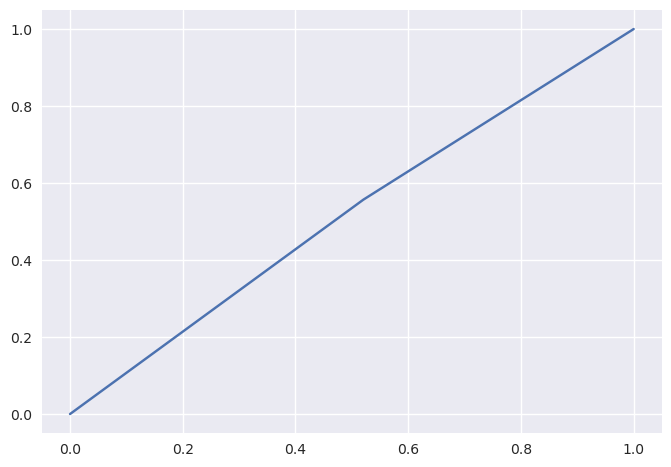

In [169]:
plt.plot(tpr, fpr)

In [590]:
preds.groupby('subset').size()

subset
lnpp    330
lpnp    347
dtype: int64

In [591]:
preds.groupby(['subset']).subject.nunique()

subset
lnpp    133
lpnp    136
Name: subject, dtype: int64

Text(0.5, 0, '')

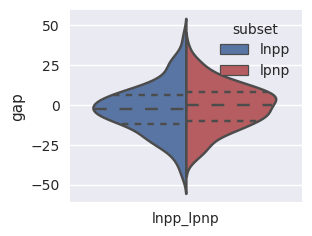

In [592]:
fig, ax = plt.subplots(1,1,figsize=(3, 2.5))
ax = sns.violinplot(
    subj_preds, y='gap', x='dataset', 
    hue='pathological' if ds_name=='lnp_lp' else 'subset', split=True, palette=['b', 'r'], 
    inner='quartile',
    ax=ax,
)
ax.set_xlabel('')

In [593]:
incorporate_passed_time = True
#consider_all_gaps = True

In [594]:
def average_same_day_recs(g):
    g_avg = g.groupby(['dataset', 'subset', 'year', 'month', 'day', 'pathological'], as_index=False).mean(numeric_only=True)
    return g_avg

In [595]:
# TODO: are we interested in change of brain age gap over time or brain age over time?

In [596]:
diffs = []
# for every subject in every dataset
for (s, ss), g in preds.groupby(['subject', 'subset'], as_index=False):
    # average recordings on same day
    g = average_same_day_recs(g)
    #g = g.groupby(['year', 'month', 'day'], as_index=False).mean(numeric_only=True)
    # if all recordings conducted on same day, continue
    if len(g) < 2:
        continue

    # make sure everything is sorted chronologically
    g = g.sort_values(['year', 'month', 'day', 'session', 'segment'])
        
    # compute diff of gap and recording dates per subject
    diff_ = g[['y_pred', 'gap', 'year', 'month', 'day', 'pathological']].diff()
    diff = diff_.mean().to_frame().T

    """
    # average over all gaps
    if consider_all_gaps:
        diff = diff_.mean().to_frame().T
    
    else:
        if ds_name == 'lnp_lp':
            diff = diff_.mean().to_frame().T
        # for transition datasets only consider moment of transition
        elif ds_name == 'lpnp':
            diff = diff_[diff_.pathological==-1].copy()
        else:
            assert ds_name == 'lnpp'
            diff = diff_[diff_.pathological==1].copy()
    """

    # incorporate passed time
    if incorporate_passed_time:
        diff['rate'] = diff.y_pred/(diff.year + diff.month/12 + diff.day/365)
        #diff['rate'] = diff.gap/(diff.year + diff.month/12 + diff.day/365)
    diff['subset'] = ss
    diff['dataset'] = ds_name
    diff['subject'] = s
    diffs.append(diff)
diffs = pd.concat(diffs)

In [597]:
diffs.subject.nunique()

269

In [57]:
from scipy.stats import ranksums, kstest, brunnermunzel

In [599]:
subset1, subset2 = diffs.subset.unique()

In [600]:
# the null hypothesis that two sets of measurements are drawn from the same distribution
ranksums(diffs[diffs.subset==subset1].rate, diffs[diffs.subset==subset2].rate)

RanksumsResult(statistic=1.5126581081217396, pvalue=0.13036652577845737)

In [601]:
# The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.
kstest(diffs[diffs.subset==subset1].rate, diffs[diffs.subset==subset2].rate)

KstestResult(statistic=0.105484298982751, pvalue=0.40427221296627364, statistic_location=-2.6830715372743175, statistic_sign=-1)

In [602]:
# median
# The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.
kstest(
    diffs[diffs.subset==subset1].rate-diffs[diffs.subset==subset1].rate.median(),
    diffs[diffs.subset==subset2].rate-diffs[diffs.subset==subset2].rate.median(),
)

KstestResult(statistic=0.06871959310039806, pvalue=0.8789411040818664, statistic_location=-3.9600568395418763, statistic_sign=-1)

In [603]:
# the null hypothesis that when values are taken one by one from each group, the probabilities of getting large values in both groups are equal
brunnermunzel(diffs[diffs.subset==subset1].rate, diffs[diffs.subset==subset2].rate)

BrunnerMunzelResult(statistic=-1.5189146030713574, pvalue=0.12996847248540697)

In [604]:
# TODO: make sure order of recordings is chronological before comuting gap diff

In [605]:
diffs.sort_values('subset', inplace=True)

In [606]:
subj_counts = {'lnp': 0, 'lp': 0, 'lnpp': 0, 'lpnp': 0}
subj_counts.update(diffs.groupby('subset').subject.nunique().to_dict())

In [607]:
diffs = diffs.replace({
    'lnp': f'RNP (n={subj_counts["lnp"]})', 
    'lp': f'RP (n={subj_counts["lp"]})', 
    'lnpp': f'TNPP (n={subj_counts["lnpp"]})', 
    'lpnp': f'TPNP (n={subj_counts["lpnp"]})',
})

In [608]:
diffs.value_counts('subset')

subset
TPNP (n=136)    136
TNPP (n=133)    133
dtype: int64

In [609]:
diffs.groupby('subset').subject.nunique()

subset
TNPP (n=133)    133
TPNP (n=136)    136
Name: subject, dtype: int64

In [610]:
diffs

,y_pred,gap,year,month,day,pathological,rate,subset,dataset,subject
0,-13.910608,-20.951362,11.000000,2.000000,27.000000,1.000000,-1.237528,TNPP (n=133),lnpp_lpnp,15.0
0,0.568932,0.571536,0.000000,1.000000,-9.000000,1.000000,9.696190,TNPP (n=133),lnpp_lpnp,4467.0
0,11.006502,8.816009,0.000000,1.000000,4.000000,1.000000,116.727549,TNPP (n=133),lnpp_lpnp,14840.0
0,3.148867,-3.686355,6.000000,2.000000,7.000000,1.000000,0.509044,TNPP (n=133),lnpp_lpnp,4610.0
0,21.690494,15.079648,1.000000,0.000000,10.000000,1.000000,21.112080,TNPP (n=133),lnpp_lpnp,4623.0
...,...,...,...,...,...,...,...,...,...,...
0,-3.415243,-2.978935,0.333333,-0.666667,5.666667,-0.333333,-11.644081,TPNP (n=136),lnpp_lpnp,5659.0
0,22.443796,16.685609,0.000000,7.000000,18.000000,-1.000000,35.475939,TPNP (n=136),lnpp_lpnp,5688.0
0,10.518932,6.489845,1.000000,1.666667,1.000000,-0.333333,9.213970,TPNP (n=136),lnpp_lpnp,1141.0
0,13.504414,7.990565,2.000000,5.000000,10.000000,-1.000000,5.525393,TPNP (n=136),lnpp_lpnp,5218.0


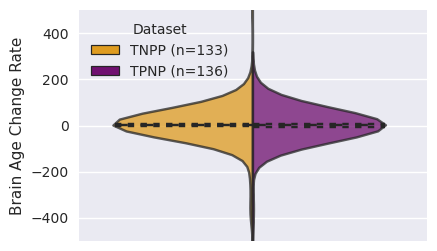

In [614]:
fig, ax = plt.subplots(1,1,figsize=(4.5, 3))
ax = sns.violinplot(
    diffs, 
    y='rate', 
    x='dataset',
    hue='subset', 
    split=True, 
    #palette={'RNP': 'b', 'RP': 'r', 'TNPP': 'purple', 'TPNP': 'orange'}, 
    palette=['orange', 'purple'] if 'lnpp_lpnp' in diffs.dataset.values else ['b', 'r'],
    inner='quartile',
    ax=ax,
)
ax.set_ylim(-500, 500) if 'lnpp_lpnp' in diffs.dataset.values else ax.set_ylim(-1250, 1250)
ax.set_ylabel('Brain Age Change Rate')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.legend(title='Dataset', loc='upper left')

from matplotlib.collections import PolyCollection
for art in ax.get_children():
    if isinstance(art, PolyCollection):
        art.set_alpha(.75)

In [758]:
import scipy
diff_lnp = diffs[diffs.subset=='lnp'].sort_values('gap').gap.values
diff_lp = diffs[diffs.subset=='lp'].sort_values('gap').gap.values
diff_lnp_extended_p = scipy.interpolate.interp1d(
    diff_lnp,
    np.linspace(0,1, len(diff_lnp)), fill_value='extrapolate')(diff_lp)


np.max(np.abs(diff_lnp_extended_p.clip(0,1) - np.linspace(0,1, len(diff_lp))))


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [102]:
diffs[diffs.subset=='lp'].gap.median()

nan

In [495]:
 = diffs[diffs.subset=='lnp'].sort_values('gap').gap.values - diffs[diffs.subset=='lp'].sort_values('gap').gap.values

SyntaxError: invalid syntax (3342619129.py, line 1)

<AxesSubplot: >

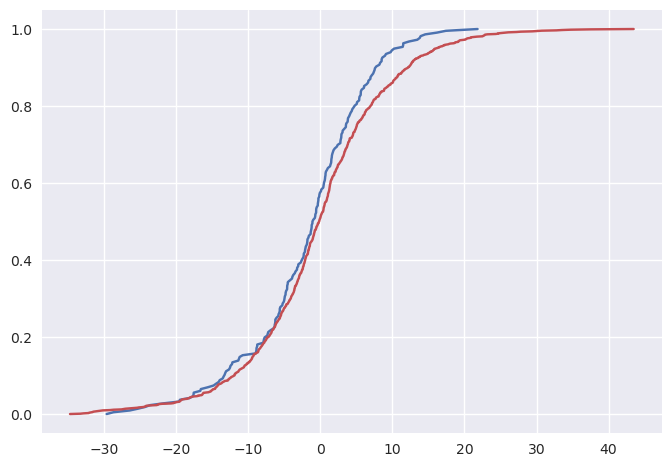

In [496]:
sns.lineplot(y=np.linspace(0, 1, len(diffs[diffs.subset=='lnp'])), x=diffs[diffs.subset=='lnp'].sort_values('gap').gap.values, c='b')
sns.lineplot(y=np.linspace(0, 1, len(diffs[diffs.subset=='lp'])), x=diffs[diffs.subset=='lp'].sort_values('gap').gap.values, c='r')

In [304]:
diffs['subset'] = diffs.subset == 'lnp'

(-500.0, 500.0)

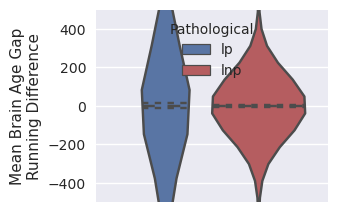

In [319]:
# TODO: .5 alpha
if ds_name == 'lnp_lp':
    palette = ['b', 'r']
if ds_name == 'lnpp':
    palette = ['purple']
if ds_name == 'lpnp':
    palette = ['orange']

fig, ax = plt.subplots(1,1,figsize=(3, 2.5))
ax = sns.violinplot(
    diffs, y='gap', x='dataset',
    hue='subset', 
    #split=True if ds_name == 'lnp_lp' else False, 
    palette=palette, 
    inner='quartile',
    ax=ax,
)
#ax.set_xlabel('LNP vs. LP' if ds_name == 'lnp_lp' else ds_name.upper())
ax.set_xlabel('')
ax.legend(title='Pathological', loc='upper center' if ds_name == 'lnp_lp' else 'upper right')
ax.set_xticklabels([])
ax.set_ylabel('Mean Brain Age Gap\nRunning Difference')
if ds_name != 'lnp_lp':
    ax.legend([])
    ax.set_ylabel('')

"""
# set violin alpha = .5
# https://github.com/mwaskom/seaborn/issues/622
from matplotlib.collections import PolyCollection
for art in ax.get_children():
    if isinstance(art, PolyCollection):
        art.set_alpha(.5)
"""

ax.set_ylim(-500, 500)

In [306]:
diffs

,subject,pathological,subset,dataset,gap,year,month,day
0,2,0.0,False,lnp_lp,126.728104,1.0,-1.500000,0.250000
1,7,0.0,False,lnp_lp,-36.750632,1.0,-0.500000,1.500000
2,17,0.0,False,lnp_lp,-3.346555,1.0,-1.000000,12.000000
3,18,0.0,True,lnp_lp,4.131152,1.0,8.000000,6.000000
4,22,0.0,False,lnp_lp,906.528418,0.0,0.000000,2.000000
...,...,...,...,...,...,...,...,...
1377,14980,0.0,False,lnp_lp,-230.485833,0.0,0.000000,1.000000
1378,14981,0.0,False,lnp_lp,331.433093,0.0,0.333333,-3.666667
1379,14988,0.0,False,lnp_lp,-491.899935,0.0,1.000000,-22.000000
1380,14993,0.0,True,lnp_lp,72.981740,0.0,2.000000,-12.000000


In [307]:
from scipy.stats import ranksums, kstest

In [308]:
ranksums(diffs[diffs.subset==0].gap, diffs[diffs.subset==1].gap)

RanksumsResult(statistic=1.2120776262967892, pvalue=0.22548266730181854)

In [88]:
kstest(diffs[diffs.subset==0].gap, diffs[diffs.subset==1].gap)

KstestResult(statistic=0.12215739403888372, pvalue=0.007680788259691022, statistic_location=80.37710555782655, statistic_sign=-1)

In [137]:
ranksums(lnpp_diffs.gap, lpnp_diffs.gap)

RanksumsResult(statistic=0.613207791696638, pvalue=0.5397389534344907)

In [138]:
kstest(lnpp_diffs.gap, lpnp_diffs.gap)

KstestResult(statistic=0.0982620320855615, pvalue=0.49509078068004614, statistic_location=-0.9711819398650859, statistic_sign=-1)

In [ ]:
lpnp_subj_preds = preds.groupby(['pathological', 'subject'], as_index=False).mean(numeric_only=True)

In [ ]:
lpnp_subj_preds.sort_values('subject', inplace=True)

In [ ]:
lpnp_subj_preds

p=4.00E-01


<AxesSubplot: xlabel='Decoded Age – Chronological Age [years]', ylabel='Count'>

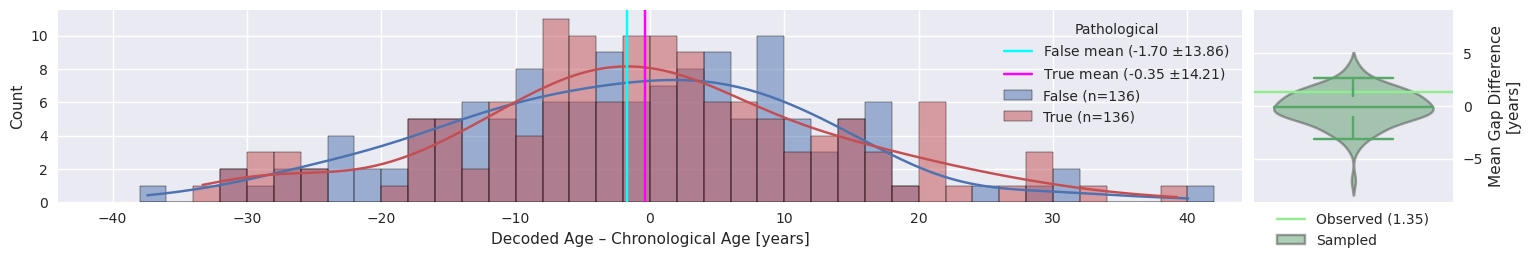

In [ ]:
plot_age_gap_hist_and_permutation_test(lpnp_subj_preds, 2, 100)

In [ ]:
n = preds.subject.nunique()

In [ ]:
np.random.RandomState(20230810)

RandomState(MT19937) at 0x7F57146E6340

In [ ]:
choices = np.random.choice(2, n)

In [ ]:
for p, g in lpnp_subj_preds.groupby('pathological'):
    break

In [ ]:
p

0.0

In [ ]:
g.sort_values('subject', inplace=True)

In [156]:
#TODO: permutation of label transition direction

In [157]:
assert ('lnpp' == preds.subset).any()

In [158]:
flip = False

In [159]:
# TODO: also incorporate psased time?
moment_of_transition = []
for (ds_name, s), g in preds.groupby(['subset', 'subject'], as_index=False):
    d = g[['gap', 'pathological', 'year', 'month', 'day', 'y_pred']]
    if flip:
        d = d[::-1]
    d = d.diff()
    cond = (d.pathological == -1) | (d.pathological == 1)
    g = g[cond]
    g = g.copy()
    g['gap_rate'] = d[cond].gap/(d[cond].year + d[cond].month/12 + d[cond].day/365)
    g['pred_rate'] = d[cond].y_pred/(d[cond].year + d[cond].month/12 + d[cond].day/365)
    moment_of_transition.append(g)
moment_of_transition = pd.concat(moment_of_transition)

In [160]:
# TODO: catch impossible values. not like below but clean
moment_of_transition = moment_of_transition[~np.isinf(moment_of_transition.gap_rate)].copy()

In [161]:
moment_of_transition.subset = moment_of_transition.subset.apply(lambda x: x.upper())

In [162]:
moment_of_transition

,dataset,subset,index,y_true,y_pred,year,month,day,subject,session,...,date_age,report_age,seed,valid_set_i,gap,y_pred_confounded,y_pred_deconfounded_linear,y_pred_deconfounded_quadratic,gap_rate,pred_rate
1,lnpp_lpnp,LNPP,1,58.999999,40.824981,2015.0,12.0,28.0,15.0,3.0,...,59.0,59.0,20230216.0,0.0,-17.013826,41.986173,41.857148,40.824981,-1.863894,-1.237528
4,lnpp_lpnp,LNPP,4,25.000000,51.472251,2008.0,7.0,7.0,32.0,3.0,...,25.0,24.0,20230216.0,0.0,24.826028,49.826028,52.543669,51.472251,5.688318,9.276571
6,lnpp_lpnp,LNPP,6,75.999998,54.146001,2003.0,3.0,3.0,49.0,2.0,...,76.0,75.0,20230216.0,0.0,-24.202510,51.797487,55.230969,54.146001,422.211962,564.341686
8,lnpp_lpnp,LNPP,8,37.000001,21.027030,2004.0,10.0,11.0,68.0,6.0,...,37.0,37.0,20230216.0,0.0,-11.028439,25.971561,20.027602,21.027030,-9.333945,-10.680132
12,lnpp_lpnp,LNPP,12,62.000002,74.610399,2004.0,10.0,25.0,78.0,2.0,...,62.0,62.0,20230216.0,0.0,3.464831,65.464833,73.860952,74.610399,5.097678,8.668485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,lnpp_lpnp,LPNP,336,54.000002,43.665047,2016.0,6.0,27.0,14284.0,2.0,...,54.0,53.0,20230216.0,0.0,-9.853609,44.146393,44.801748,43.665047,3.743617,4.702134
668,lnpp_lpnp,LPNP,338,85.000002,71.386315,2016.0,7.0,6.0,14332.0,2.0,...,85.0,84.0,20230216.0,0.0,-21.346957,63.653045,71.391300,71.386315,80.353705,116.262130
670,lnpp_lpnp,LPNP,340,33.000001,35.654956,2016.0,2.0,5.0,14382.0,2.0,...,33.0,32.0,20230216.0,0.0,4.938402,37.938403,36.339626,35.654956,-66.618664,-90.048796
672,lnpp_lpnp,LPNP,342,22.000000,23.222174,2016.0,9.0,26.0,14522.0,2.0,...,22.0,21.0,20230216.0,0.0,5.948781,27.948781,22.722754,23.222174,37.608063,44.502272


In [165]:
moment_of_transition = moment_of_transition.replace({'LNPP': 'TNPP', 'LPNP': 'TPNP'})

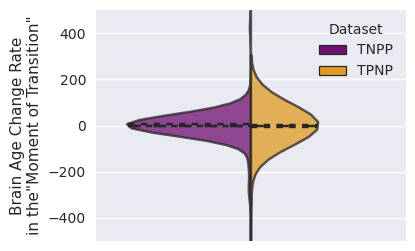

In [166]:
fig, ax = plt.subplots(1,1,figsize=(4, 3))
ax = sns.violinplot(
    data=moment_of_transition,
    hue='subset',
    x='dataset',
    y='gap_rate',#'pred_rate',
    split=True,
    inner='quartile',
    palette={'TNPP': 'purple', 'TPNP': 'orange'},
    ax=ax,
)
ax.legend(title='Dataset', )
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('Brain Age Change Rate\nin the"Moment of Transition"')
ax.set_ylim(-500, 500)

from matplotlib.collections import PolyCollection
for art in ax.get_children():
    if isinstance(art, PolyCollection):
        art.set_alpha(.75)

In [151]:
ranksums(
    moment_of_transition[moment_of_transition.subset == 'LNPP'].gap_rate, 
    moment_of_transition[moment_of_transition.subset == 'LPNP'].gap_rate,
)

RanksumsResult(statistic=0.677838947119677, pvalue=0.4978738137683999)

In [152]:
brunnermunzel(
    moment_of_transition[moment_of_transition.subset == 'LNPP'].gap_rate, 
    moment_of_transition[moment_of_transition.subset == 'LPNP'].gap_rate,
)

BrunnerMunzelResult(statistic=-0.6349525490638073, pvalue=0.5260058004388859)

In [153]:
kstest(
    moment_of_transition[moment_of_transition.subset == 'LNPP'].gap_rate, 
    moment_of_transition[moment_of_transition.subset == 'LPNP'].gap_rate,
)

KstestResult(statistic=0.0982620320855615, pvalue=0.49509078068004614, statistic_location=-0.9711819398650859, statistic_sign=-1)

In [122]:
preds

,index,subject,year,month,day,session,segment,y_true,y_pred,sfreq,...,date_age,report_age,seed,valid_set_i,gap,y_pred_confounded,y_pred_deconfounded_linear,y_pred_deconfounded_quadratic,subset,dataset
0,0,21,2006,3,20,1,0,27.999999,53.535834,250.0,...,28.0,27.0,20230216.0,0.0,23.261840,51.261840,54.500826,53.535834,lpnp,lpnp
1,1,21,2006,4,17,2,0,27.999999,40.711683,250.0,...,28.0,27.0,20230216.0,0.0,13.600694,41.600693,41.331700,40.711683,lpnp,lpnp
2,2,21,2006,6,16,3,0,27.999999,42.616122,250.0,...,28.0,27.0,20230216.0,0.0,15.194220,43.194219,43.503838,42.616122,lpnp,lpnp
3,3,21,2015,12,17,5,0,37.000001,41.161664,256.0,...,37.0,37.0,20230216.0,0.0,5.221327,42.221328,42.177688,41.161664,lpnp,lpnp
4,4,94,2003,4,2,1,0,64.000001,47.429630,250.0,...,64.0,63.0,20230216.0,0.0,-17.170318,46.829682,48.459344,47.429630,lpnp,lpnp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,342,14522,2016,9,26,2,0,22.000000,23.222174,250.0,...,22.0,21.0,20230216.0,0.0,5.948781,27.948781,22.722754,23.222174,lpnp,lpnp
343,343,14672,2016,5,19,1,1,49.000000,56.414536,250.0,...,49.0,48.0,20230216.0,0.0,4.416801,53.416801,57.438258,56.414536,lpnp,lpnp
344,344,14672,2016,6,8,2,0,49.000000,48.857502,512.0,...,49.0,48.0,20230216.0,0.0,-1.008540,47.991460,50.042966,48.857502,lpnp,lpnp
345,345,14672,2016,6,20,4,0,49.000000,34.837753,256.0,...,49.0,48.0,20230216.0,0.0,-11.794977,37.205023,35.339954,34.837753,lpnp,lpnp


In [112]:
# expected lnp vs lp
# 245+1321 subjects
# 3963+621 recordings

In [130]:
# average over seeds of FE
preds.reset_index().groupby(['index', 'subject', 'year', 'month', 'day', 'session', 'segment']).mean(numeric_only=True)

y_true     y_pred  sfreq  \
index subject year month day session segment                                
0     2       2002 12    26  3       0        55.000001  28.330664  250.0   
      18      2006 3     13  1       0        50.999999  46.950042  250.0   
1     2       2003 1     7   6       1        56.000001  50.927886  250.0   
      18      2007 11    19  2       0        52.000001  57.699865  250.0   
2     2       2003 3     14  7       0        56.000001  40.813451  250.0   
...                                                 ...        ...    ...   
3958  15026   2016 8     1   2       1        67.999998  40.655477  256.0   
3959  15026   2016 8     1   5       1        67.999998  37.842462  256.0   
3960  15026   2016 8     1   4       8        67.999998  51.974991  256.0   
3961  15026   2016 8     1   4       11       67.999998  49.849819  256.0   
3962  15026   2016 8     1   4       12       67.999998  49.112125  256.0   

                                              n_samples   age  gender  \
index subject year month day session segment                            
0     2       2002 12    26  3       0         307250.0  55.0     1.0   
      18      2006 3     13  1       0         300250.0  51.0     1.0   
1     2       2003 1     7   6       1         303000.0  56.0     1.0   
      18      2007 11    19  2       0         361750.0  52.0     1.0   
2     2       2003 3     14  7       0         321000.0  56.0     1.0   
...                                                 ...   ...     ...   
3958  15026   2016 8     1   2       1        6428672.0  68.0     1.0   
3959  15026   2016 8     1   5       1        2172160.0  68.0     1.0   
3960  15026   2016 8     1   4       8         250368.0  68.0     1.0   
3961  15026   2016 8     1   4       11       1601792.0  68.0     1.0   
3962  15026   2016 8     1   4       12       8043264.0  68.0     1.0   

                                              pathological  train  date_age  \
index subject year month day session segment                                  
0     2       2002 12    26  3       0                 1.0    1.0      55.0   
      18      2006 3     13  1       0                 0.0    1.0      51.0   
1     2       2003 1     7   6       1                 1.0    1.0      56.0   
      18      2007 11    19  2       0                 0.0    1.0      52.0   
2     2       2003 3     14  7       0                 1.0    1.0      56.0   
...                                                    ...    ...       ...   
3958  15026   2016 8     1   2       1                 1.0    0.0      68.0   
3959  15026   2016 8     1   5       1                 1.0    0.0      68.0   
3960  15026   2016 8     1   4       8                 1.0    0.0      68.0   
3961  15026   2016 8     1   4       11                1.0    0.0      68.0   
3962  15026   2016 8     1   4       12                1.0    0.0      68.0   

                                              report_age        seed  \
index subject year month day session segment                           
0     2       2002 12    26  3       0              55.0  20230216.0   
      18      2006 3     13  1       0              50.0  20230216.0   
1     2       2003 1     7   6       1              55.0  20230216.0   
      18      2007 11    19  2       0              52.0  20230216.0   
2     2       2003 3     14  7       0              55.0  20230216.0   
...                                                  ...         ...   
3958  15026   2016 8     1   2       1              67.0  20230216.0   
3959  15026   2016 8     1   5       1              67.0  20230216.0   
3960  15026   2016 8     1   4       8              67.0  20230216.0   
3961  15026   2016 8     1   4       11             67.0  20230216.0   
3962  15026   2016 8     1   4       12             67.0  20230216.0   

                                              valid_set_i        gap  \
index subject year month day session segment                

In [193]:
#ds_names = ['longitudinal_non_pathological', 'longitudinal_pathological', 'longitudinal_transition']  # longitudinal datasets old
ds_names = ['lnp', 'lp', 'lnpp', 'lpnp']  # longitudinal datasets new
#ds_names = ['nlnp', 'nlp', 'nlnpp', 'nlpnp']  # sampled datasets not longitudinal but same size for comparison
#min_mins = 15
#clean_age = True

In [194]:
reload = True
# these are predictions of five repetitions of fe
if reload:
    all_rec_preds = {ds_name: get_longitudinal_preds(ds_name) for ds_name in ds_names}
else:
    with open(f'/home/jovyan/long_{min_mins}_{clean_age}.pkl', 'rb') as f:
        all_rec_preds = pickle.load(f)

NameError: name 'get_longitudinal_preds' is not defined

In [306]:
# there should be at least 2 recs per subjects and recs should be at least 15 mins of duration

In [307]:
for ds_name, rec_preds in all_rec_preds.items():
    assert all(all_rec_preds[ds_name].groupby('subject').size() > 2)
    assert all(all_rec_preds[ds_name].n_samples / all_rec_preds[ds_name].sfreq >= min_mins*60)
    print(ds_name, rec_preds.shape, rec_preds.subject.nunique())

nlnp (1865, 26) 373
nlp (13885, 26) 2760
nlnpp (1145, 26) 229
nlpnp (1165, 26) 233


In [308]:
# map gender from M, F to 0, 1
all_rec_preds = {ds_name: rec_preds.replace({'M': 0, 'F': 1}) for ds_name, rec_preds in all_rec_preds.items()}

In [309]:
for ds_name in ds_names:
    print(ds_name)
    counts(all_rec_preds[ds_name])
    print()

nlnp
1865 recs of 373 subjects
per seed 373 recs of 373 subjects
thereof female 0    195
1    178
Name: gender, dtype: int64

nlp
13885 recs of 2760 subjects
per seed 2777 recs of 2760 subjects
thereof female 1    1424
0    1336
Name: gender, dtype: int64

nlnpp
1145 recs of 229 subjects
per seed 229 recs of 229 subjects
thereof female 0    130
1     99
Name: gender, dtype: int64

nlpnp
1165 recs of 233 subjects
per seed 233 recs of 233 subjects
thereof female 0    132
1    101
Name: gender, dtype: int64



In [310]:
# average predictions over five runs of fe
grouper = ['subset', 'index']
all_rec_preds = {
    ds_name: all_rec_preds[ds_name].reset_index().groupby(grouper, as_index=False).mean(numeric_only=True)
    for ds_name in ds_names
}

In [311]:
for ds_name in ds_names:
    print(ds_name)
    counts(all_rec_preds[ds_name])
    print()

nlnp
373 recs of 373 subjects
per seed 373 recs of 373 subjects
thereof female 0.0    195
1.0    178
Name: gender, dtype: int64

nlp
2777 recs of 2760 subjects
per seed 2777 recs of 2760 subjects
thereof female 1.0    1424
0.0    1336
Name: gender, dtype: int64

nlnpp
229 recs of 229 subjects
per seed 229 recs of 229 subjects
thereof female 0.0    130
1.0     99
Name: gender, dtype: int64

nlpnp
233 recs of 233 subjects
per seed 233 recs of 233 subjects
thereof female 0.0    132
1.0    101
Name: gender, dtype: int64



In [313]:
save_figures = False

In [314]:
ylims.keys()

dict_keys(['lnp', 'lp', 'lnpp', 'lpnp'])

In [315]:
#ylims = {'non_pathological': 13, 'pathological': 55, 'transition': 12}  # 15 min, clean age
#ylims = {'non_pathological': 120, 'pathological': 400, 'transition': 120}  # 2 min, dirty age
#ylims = {'longitudinal_non_pathological': 40, 'longitudinal_pathological': 120, 'longitudinal_transition': 30}  # 15 min, dirty age
ylims = {'lnp': 40, 'lp': 120, 'lnpp': 30, 'lpnp': 30}
for ds_name, rec_preds in all_rec_preds.items():
    ax_arr = age_pyramid(rec_preds, f'eval_{ds_name}', ylim=ylims[ds_name], show_title=False)
    if save_figures:
        save_fig(ax_arr[0].get_figure(), '/home/jovyan/figures/', f'{ds_name}_{min_mins}_{clean_age}_age_pyramid')

KeyError: 'nlnp'

# deconfound predictions

In [316]:
all_rec_preds = {
    ds_name: add_deconfounded_predictions(rec_preds, coeffs)[0]
    for ds_name, rec_preds in all_rec_preds.items()
}

In [317]:
coeffs

{'linear': [-0.36310181197536046, 15.374280445171014],
 'quadratic': [-0.004431773520303435, 0.05752921309654997, 6.582235069495847]}

In [318]:
# average over seeds / runs, subject, subset, and pathology status
all_subj_preds = {
    ds_name: rec_preds.groupby(['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)
    for ds_name, rec_preds in all_rec_preds.items()
}

In [319]:
for ds_name in ds_names:
    print(ds_name)
    counts(all_subj_preds[ds_name])
    print()

nlnp
373 recs of 373 subjects
per seed 373 recs of 373 subjects
thereof female 0.0    195
1.0    178
Name: gender, dtype: int64

nlp
2769 recs of 2760 subjects
per seed 2769 recs of 2760 subjects
thereof female 1.0    1424
0.0    1336
Name: gender, dtype: int64

nlnpp
229 recs of 229 subjects
per seed 229 recs of 229 subjects
thereof female 0.0    130
1.0     99
Name: gender, dtype: int64

nlpnp
233 recs of 233 subjects
per seed 233 recs of 233 subjects
thereof female 0.0    132
1.0    101
Name: gender, dtype: int64



In [320]:
# TODO: simply count increase in gap for non-patho, patho, pnp and npp?

In [321]:
bin_size = 2
n_repetitions = 100
#detrend = True
#thresh1 = -8.786315726356626 
#thresh2 = 4.877341101987973 
#thresh1 = -7.186685473771377
#thresh2 = 5.955300372252786

In [322]:
# for everything that follows, use deconfounded predictions
for ds_name in all_rec_preds.keys():
    all_rec_preds[ds_name]['y_pred'] = all_rec_preds[ds_name]['y_pred_deconfounded_quadratic']
for ds_name in all_subj_preds.keys():
    all_subj_preds[ds_name]['y_pred'] = all_subj_preds[ds_name]['y_pred_deconfounded_quadratic']

In [323]:
save_figures = False

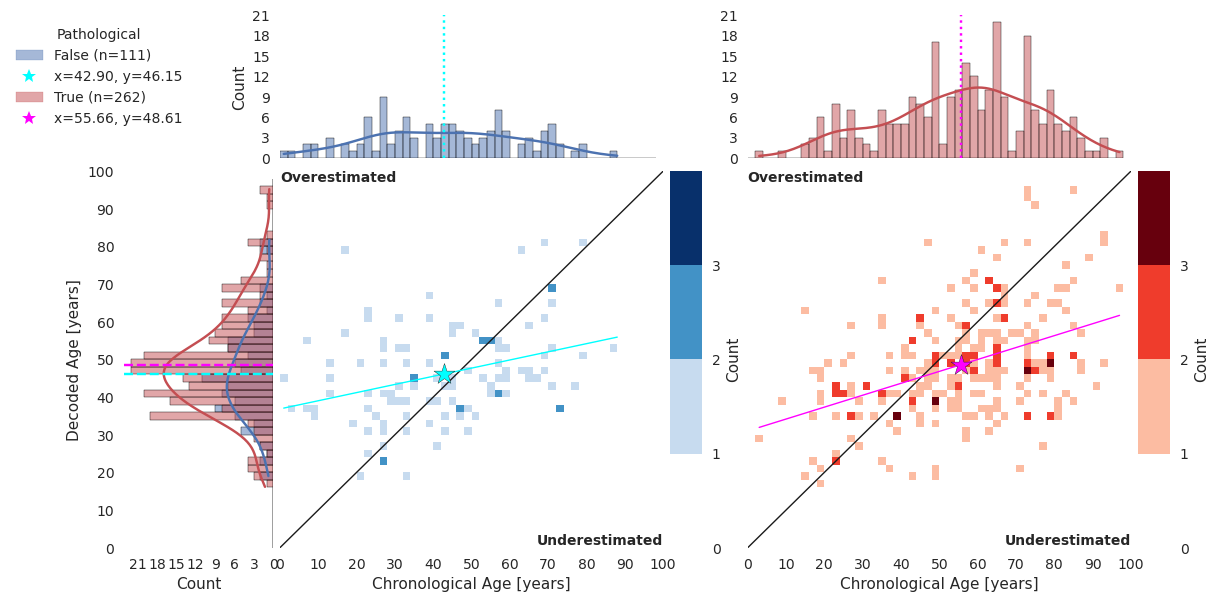

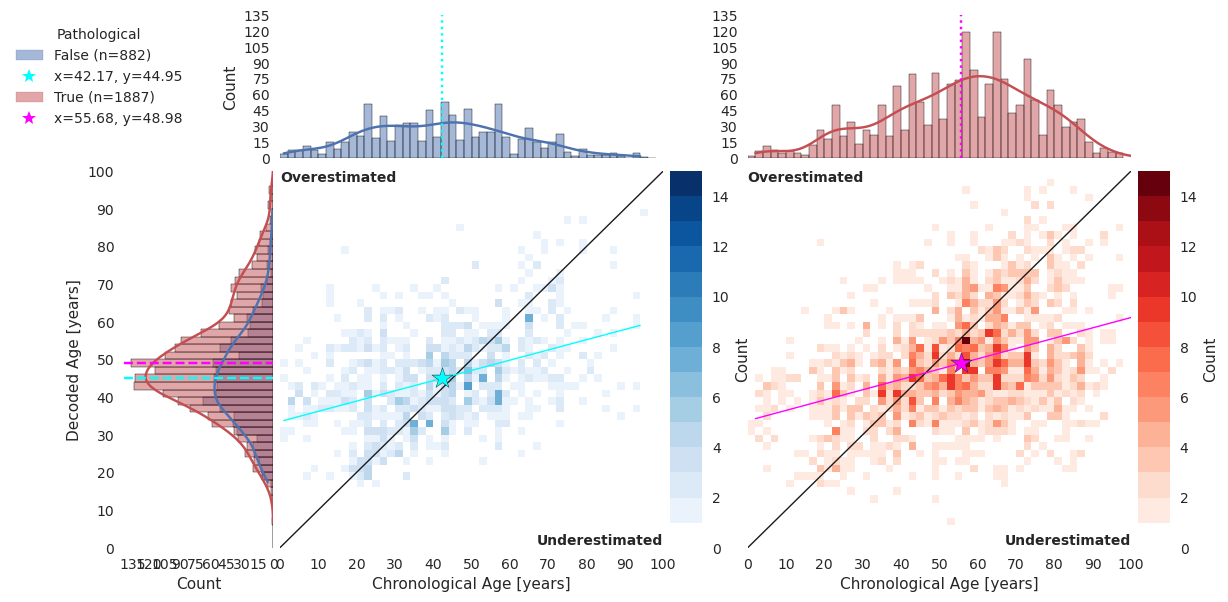

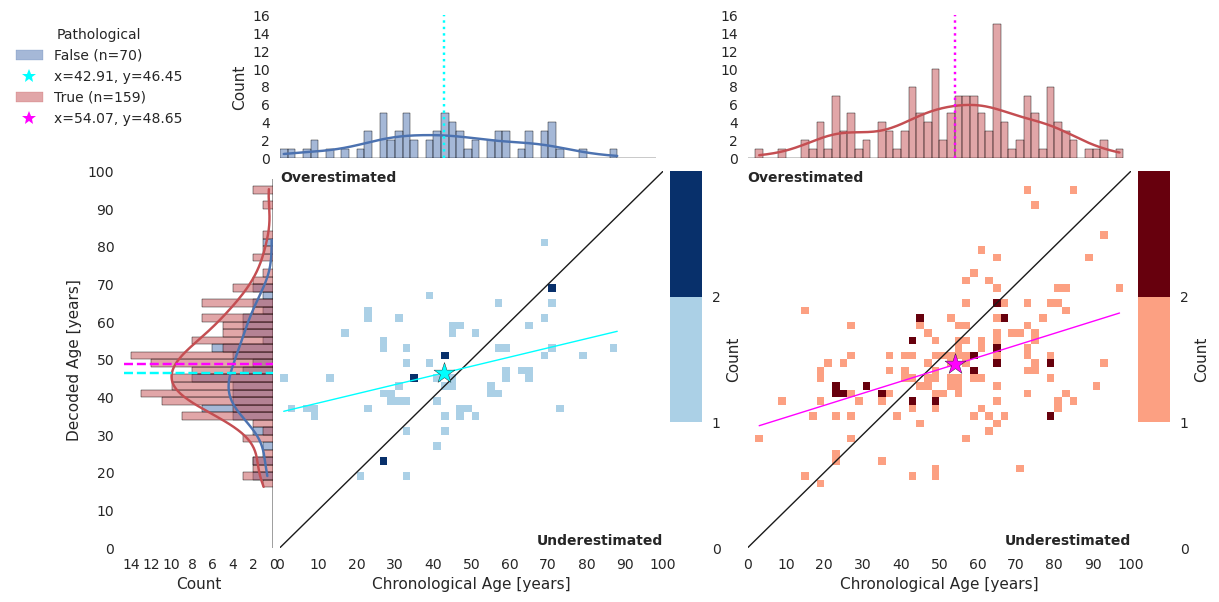

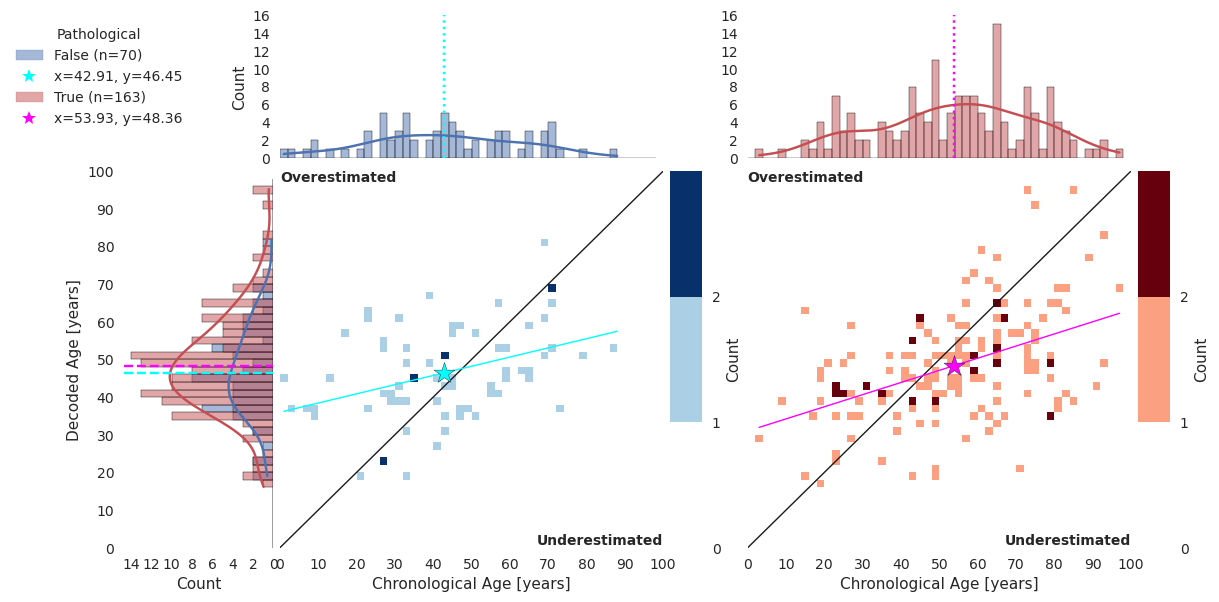

In [324]:
for ds_name, subj_preds in all_subj_preds.items():
    ax = plot_heatmaps(subj_preds, bin_size)
    if save_figures:
        save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_{min_mins}_{clean_age}_age_heatmap')

# all transitions

In [325]:
for ds_name in all_subj_preds.keys():
    rec_preds = all_rec_preds[ds_name]
    subj_preds = all_subj_preds[ds_name]
    print(ds_name)
    if ds_name.startswith('transition'):
        """
        ax = plot_age_gap_hist_and_permutation_test(subj_preds, bin_size, n_repetitions)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_gap_histogram')
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            subj_preds,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_gap_proxy')
        """
        ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
            subj_preds,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'lt_{min_mins}_{clean_age}_age_gap_proxy')
        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
            mean_abs_running_diff_of_mean_corrected_gaps(rec_preds), 
            n_repetitions,
            bin_width,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_{min_mins}_{clean_age}_running_age_gap')
"""
    else:
        ax = plot_age_gap_hist(subj_preds, bin_size)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_gap_histogram')
        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps(
            mean_abs_running_diff_of_mean_corrected_gaps(rec_preds),
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_running_age_gap')
"""

nlnp
nlp
nlnpp
nlpnp


"\n    else:\n        ax = plot_age_gap_hist(subj_preds, bin_size)\n        if save_figures:\n            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_gap_histogram')\n        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps(\n            mean_abs_running_diff_of_mean_corrected_gaps(rec_preds),\n        )\n        if save_figures:\n            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_running_age_gap')\n"

In [268]:
# compare LNP and LP datasets with permutation test

In [269]:
n_repetitions = 100
save_figures = False

p=1.00E-02
p=2.50E-01
p=1.00E-02


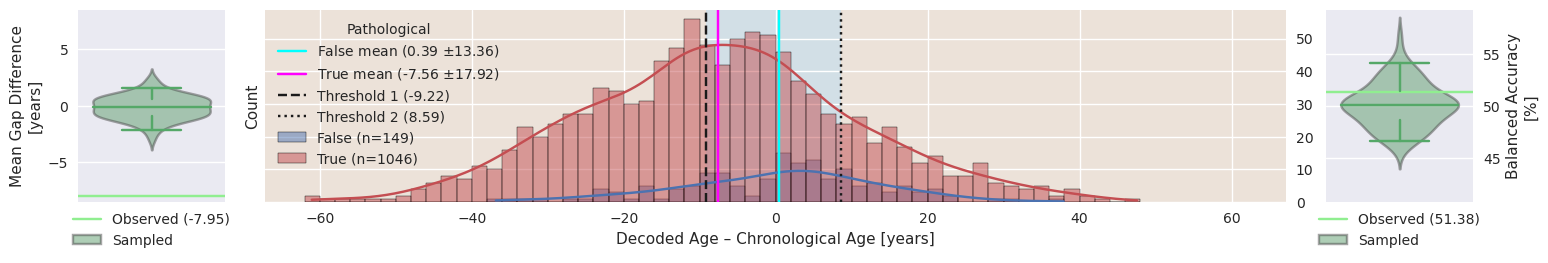

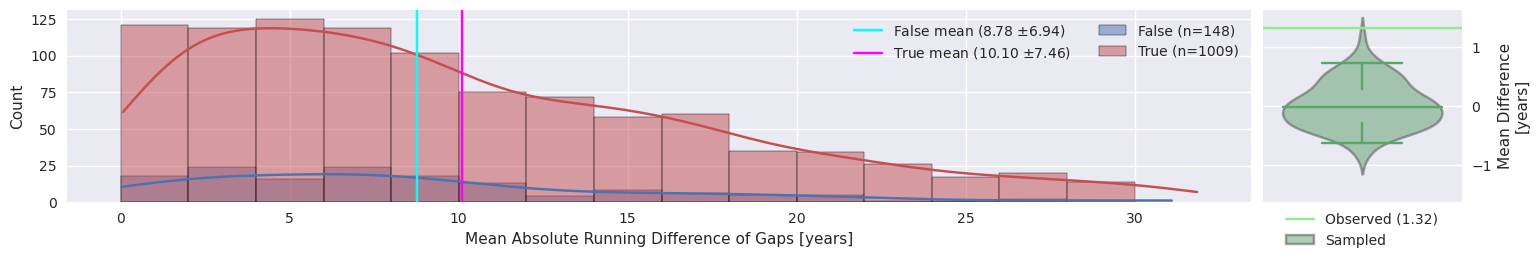

In [93]:
# compare LNP and LP datasets with permutation test
lnp_lp_subj_preds = pd.concat([all_subj_preds['non_pathological'], all_subj_preds['pathological']])
"""
ax = plot_age_gap_hist_and_permutation_test(lnp_lp_subj_preds, bin_size, n_repetitions)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'lnp_lp_age_gap_comparison')
"""
ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
    lnp_lp_subj_preds,
    t_low,
    t_high,
    bin_size,
    n_repetitions,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'lnp_lp_{min_mins}_{clean_age}_age_gap_proxy')
lnp_lp_rec_preds = pd.concat([all_rec_preds['non_pathological'], all_rec_preds['pathological']])
ax = plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
    mean_abs_running_diff_of_mean_corrected_gaps(lnp_lp_rec_preds), 
    n_repetitions,
    bin_width,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'lnp_lp_{min_mins}_{clean_age}_running_gap_comparison')

In [94]:
bin_size = 2
n_repetitions = 100
save_figures = False

237 recs of 98 subjects
per seed 237 recs of 98 subjects
thereof female 1.0    56
0.0    42
Name: gender, dtype: int64

240 recs of 100 subjects
per seed 240 recs of 100 subjects
thereof female 1.0    52
0.0    48
Name: gender, dtype: int64


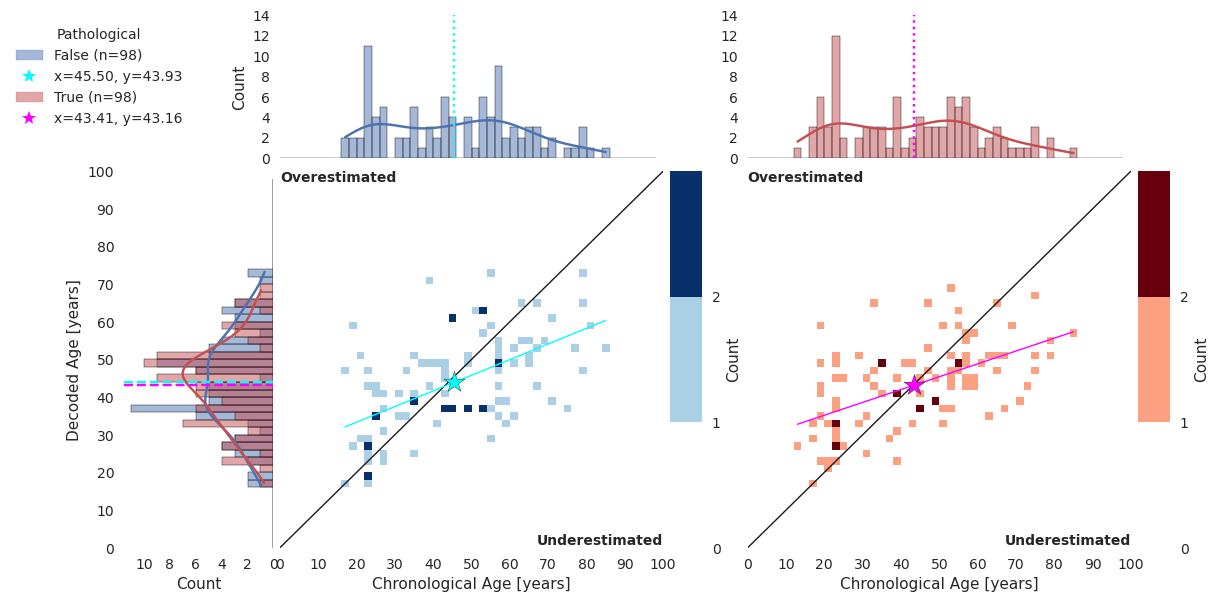

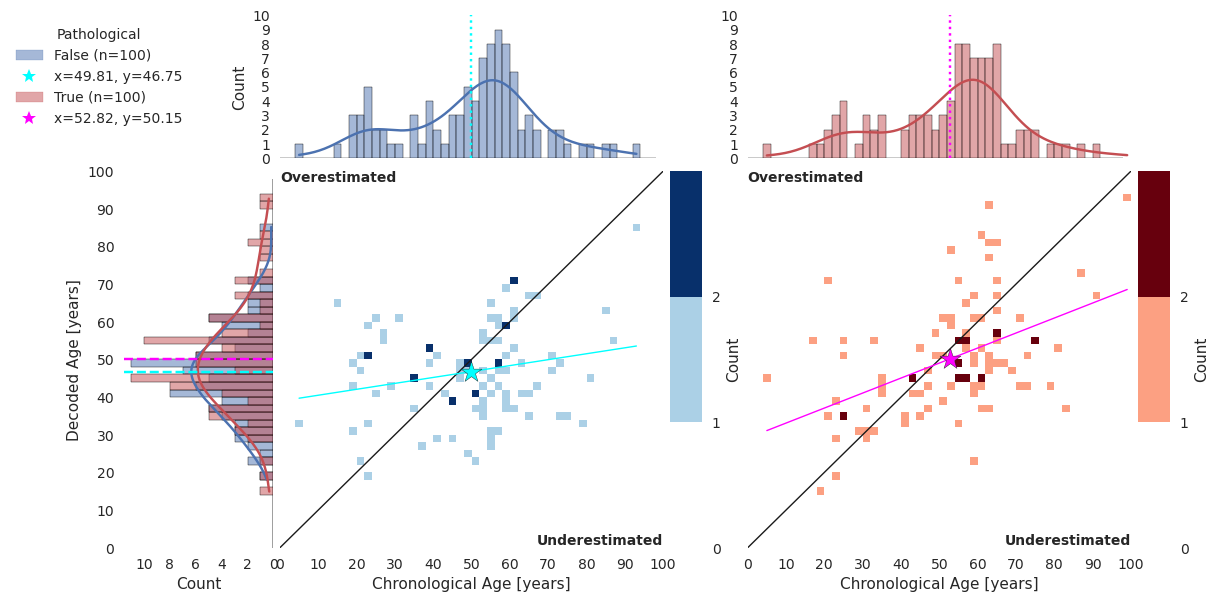

In [95]:
for ds_name, rec_preds in all_rec_preds.items():
    if ds_name.startswith('transition'):
        gs_01, gs_10 = get_01_10_transitions(rec_preds)
        counts(gs_01)
        print()
        counts(gs_10)

        # average over runs / seeds
        gs_01_subj = gs_01.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)
        gs_10_subj = gs_10.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)

        #plot_heatmaps(gs_01, bin_size)
        ax = plot_heatmaps(gs_01_subj, bin_size)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_{min_mins}_{clean_age}_age_heatmap')
        #plot_heatmaps(gs_10, bin_size)
        ax = plot_heatmaps(gs_10_subj, bin_size)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_{min_mins}_{clean_age}_age_heatmap')

# 01 transitions

non_pathological
pathological
transition
p=5.20E-01
p=1.40E-01
p=3.80E-01


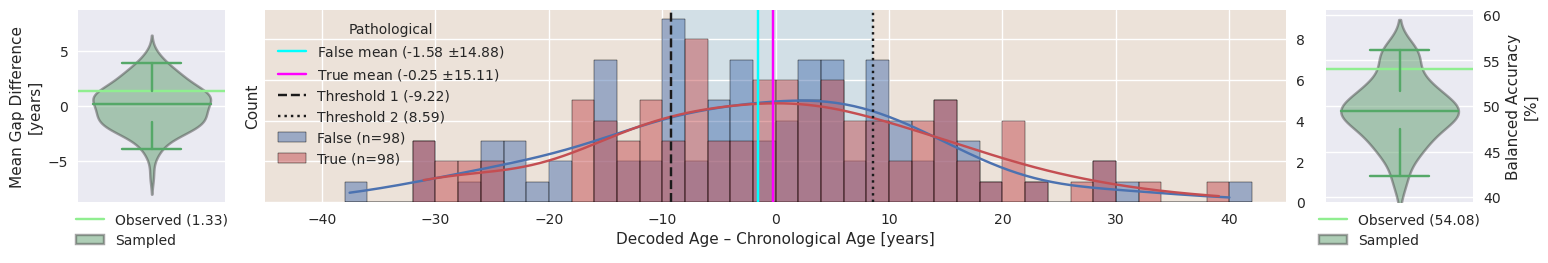

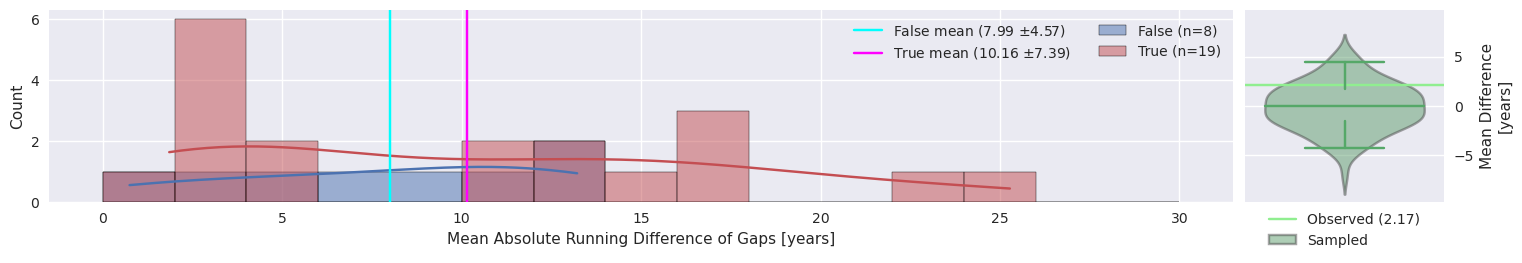

In [96]:
for ds_name in all_subj_preds.keys():
    rec_preds = all_rec_preds[ds_name]
    subj_preds = all_subj_preds[ds_name]
    print(ds_name)
    if ds_name.startswith('transition'):
        """
        ax = plot_age_gap_hist_and_permutation_test(gs_01_subj, bin_size, n_repetitions)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_age_gap_histogram')
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            gs_01_subj,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_age_gap_proxy')
        """
        ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
            gs_01_subj,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        # force wider xasis to fit legend in
        ax.set_xlim(-45,45)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_{min_mins}_{clean_age}_age_gap_proxy')
        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
            mean_abs_running_diff_of_mean_corrected_gaps(gs_01), 
            n_repetitions,
            bin_width,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_{min_mins}_{clean_age}_running_age_gap')

# 10 transitions

non_pathological
pathological
transition
p=8.80E-01
p=2.00E-01
p=7.40E-01


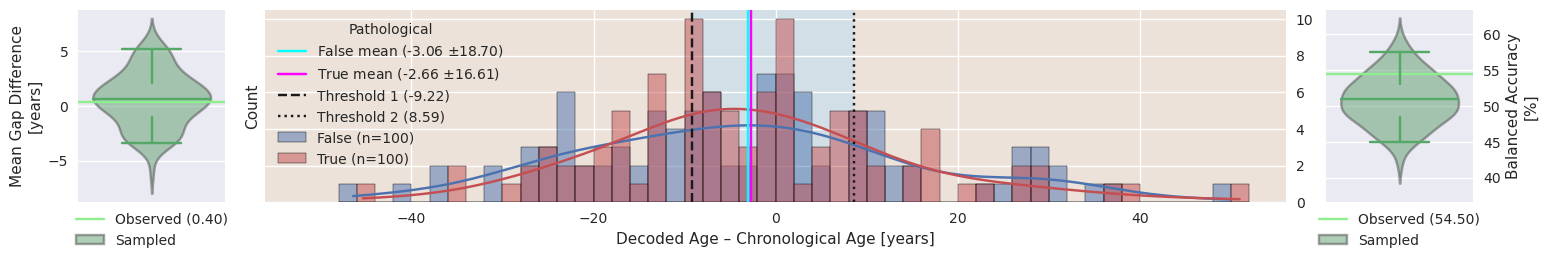

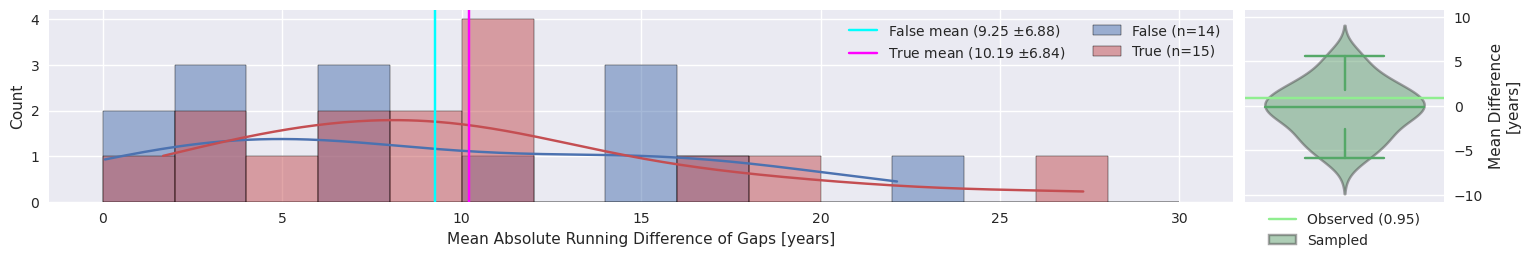

In [97]:
for ds_name in all_subj_preds.keys():
    rec_preds = all_rec_preds[ds_name]
    subj_preds = all_subj_preds[ds_name]
    print(ds_name)
    if ds_name.startswith('transition'):
        """
        ax = plot_age_gap_hist_and_permutation_test(gs_10_subj, bin_size, n_repetitions)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_age_gap_histogram')
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            gs_10_subj,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_age_gap_proxy')
        """
        ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
            gs_10_subj,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_{min_mins}_{clean_age}_age_gap_proxy')
        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
            mean_abs_running_diff_of_mean_corrected_gaps(gs_10), 
            n_repetitions,
            bin_width,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_{min_mins}_{clean_age}_running_age_gap')

In [326]:
for ds_name, subj_preds in all_subj_preds.items():
    print(ds_name, 'r2', r2_score(subj_preds.y_pred_deconfounded_quadratic, subj_preds.y_true))
    print(ds_name, 'mae', mean_absolute_error(subj_preds.y_pred_deconfounded_quadratic, subj_preds.y_true))    
    print()

nlnp r2 -1.0411270518478002
nlnp mae 15.42390924715078

nlp r2 -1.0301178728640932
nlp mae 15.355038672485131

nlnpp r2 -0.9959739083618722
nlnpp mae 15.24994321041819

nlpnp r2 -0.9893761140464741
nlpnp mae 15.225915304469252



In [ ]:
for ds_name, subj_preds in all_subj_preds.items():
    print(ds_name, 'r2', r2_score(subj_preds.y_pred_deconfounded_quadratic, subj_preds.y_true))
    print(ds_name, 'mae', mean_absolute_error(subj_preds.y_pred_deconfounded_quadratic, subj_preds.y_true))    
    print()

lnp r2 -0.808194095082915
lnp mae 10.583590486599144

lp r2 -1.8707189574223584
lp mae 15.312387555996642

lnpp r2 -0.7373328016557308
lnpp mae 14.013809749781496

lpnp r2 -0.5474319893998623
lpnp mae 12.042612108247317



In [271]:
r2_score(gs_01_subj.y_pred_deconfounded_quadratic, gs_01_subj.y_true), mean_absolute_error(gs_01_subj.y_pred_deconfounded_quadratic, gs_01_subj.y_true)

(-0.544502438881606, 11.924485911860046)

In [272]:
r2_score(gs_10_subj.y_pred_deconfounded_quadratic, gs_10_subj.y_true), mean_absolute_error(gs_10_subj.y_pred_deconfounded_quadratic, gs_10_subj.y_true)

(-0.7380359776714693, 13.899122748900343)

In [327]:
for ds_name, subj_preds in all_subj_preds.items():
    print(ds_name, 'r2', r2_score(subj_preds.y_pred_deconfounded_quadratic, len(subj_preds) * [subj_preds.y_true.mean()]))
    print(ds_name, 'mae', mean_absolute_error(subj_preds.y_pred_deconfounded_quadratic, len(subj_preds) * [subj_preds.y_true.mean()]))    
    print()

nlnp r2 -0.08523102115569725
nlnp mae 11.300582826376836

nlp r2 -0.06993725576920151
nlp mae 11.519450286630535

nlnpp r2 -0.039340165147389694
nlnpp mae 10.715253944712122

nlpnp r2 -0.04386629150195853
nlpnp mae 10.755257752612943



In [273]:
for ds_name, subj_preds in all_subj_preds.items():
    print(ds_name, 'r2', r2_score(subj_preds.y_pred_deconfounded_quadratic, len(subj_preds) * [subj_preds.y_true.mean()]))
    print(ds_name, 'mae', mean_absolute_error(subj_preds.y_pred_deconfounded_quadratic, len(subj_preds) * [subj_preds.y_true.mean()]))    
    print()

lnp r2 -1.3989863214547427e-06
lnp mae 7.7653777941608855

lp r2 -0.42085341563128087
lp mae 11.043529610156918

lnpp r2 -0.04065065228342668
lnpp mae 10.925652096429152

lpnp r2 -0.005879042231357712
lpnp mae 9.865896150489997



In [102]:
r2_score(gs_01_subj.y_pred_deconfounded_quadratic, len(gs_01_subj) * [gs_01_subj.y_true.mean()]), mean_absolute_error(gs_01_subj.y_pred_deconfounded_quadratic, len(gs_01_subj) * [gs_01_subj.y_true.mean()])

(-0.00576552232761407, 9.808087474437174)

In [103]:
r2_score(gs_10_subj.y_pred_deconfounded_quadratic, len(gs_10_subj) * [gs_10_subj.y_true.mean()]), mean_absolute_error(gs_10_subj.y_pred_deconfounded_quadratic, len(gs_10_subj) * [gs_10_subj.y_true.mean()])

(-0.044680283224723505, 10.85463844014934)

                  subject  gap ratio
pathological                        
0.0           4941.838462  -2.876146
                  subject  gap ratio
pathological                        
1.0           4884.349423   0.342182
                  subject  gap ratio
pathological                        
0.0           2141.629630  -1.367525
1.0           3303.692308  -0.240189


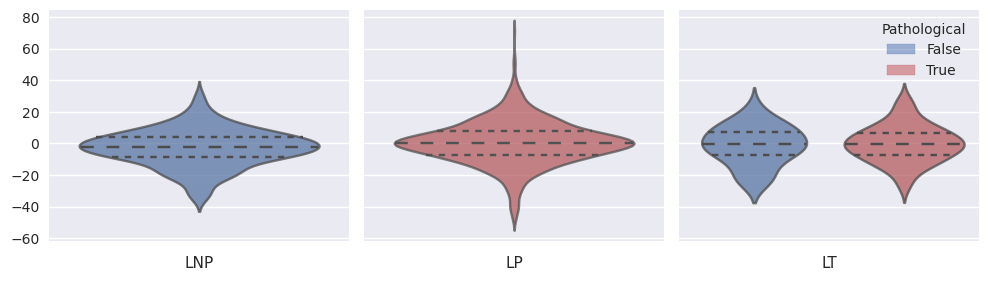

In [108]:
# compute running gap and devide by passed time
fig, ax_arr = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ds_i, ds_name in enumerate(all_rec_preds.keys()):
    m = []
    for s, g in all_rec_preds[ds_name].groupby(['subject', 'pathological'], as_index=False):
        # average same day observations
        # if everything happened on same day, continue, since no diff
        g = g.groupby(['year', 'month', 'day'], as_index=False).mean(numeric_only=True)
        if len(g) == 1:
            continue
        # TODO: how to handle same chronological age observations? -> divide by zero
        h = (g.y_pred_deconfounded_quadratic - g.y_true).diff()[1:]
        b = g.y_true.diff()[1:]
        # division by zero
        # TODO: add handling of pathology status in LT
        #b[b==0] += 1
        #h = h[b!=0]
        #b = b[b!=0]
        m.append([s[0], s[1], (h).mean()])
    m = pd.DataFrame(m, columns=['subject', 'pathological', 'gap ratio'])
    print(m.groupby('pathological').mean())

    ax = sns.violinplot(
        data=m, y='gap ratio', x='pathological' if ds_name == 'transition' else None, 
        palette=['r'] if ds_name == 'pathological' else ['b', 'r'],
        inner='quartile',
        ax=ax_arr[ds_i],
    )
    
    if ds_name == 'transition':
        import matplotlib.patches as mpatches
        patches = [
            mpatches.Patch(color='b', alpha=.5, label='False'),
            mpatches.Patch(color='r', alpha=.5, label='True'),
        ]
        ax.legend(title='Pathological', handles=patches)
    
    #for p, g in m.groupby('pathological'):
        #ax.axhline(g.median()['gap ratio'])
    
    """
    c = 'b' if ds_name == 'non_pathological' else 'r'
    sns.boxplot(
        data=m, y='gap ratio', ax=ax, x='pathological' if ds_name == 'transition' else None, 
        showfliers=False, showbox=False, whis=[25,75], palette=['b', 'r'],
    )
    **{
        'boxprops':{'facecolor':'none', 'edgecolor':c},
        'medianprops':{'color':c},
        'whiskerprops':{'color':c},
        'capprops':{'color':c}
    },
    """
    #ax.set_ylabel('Brain Age Gap Difference/\nTime Passed' if ds_name == 'non_pathological' else '')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    if ds_name == 'transition':
        ds_name = 'LT'
    elif ds_name == 'pathological':
        ds_name = 'LP'
    elif ds_name == 'non_pathological':
        ds_name = 'LNP'
    ax.set_xlabel(ds_name)
    
    # set violin alpha = .5
    # https://github.com/mwaskom/seaborn/issues/622
    from matplotlib.collections import PolyCollection
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_alpha(.75)
            
plt.subplots_adjust(wspace=.05)

In [109]:
m

,subject,pathological,gap ratio
0,5.0,1.0,10.411332
1,32.0,0.0,-22.130433
2,68.0,1.0,6.227678
3,78.0,1.0,10.703444
4,94.0,0.0,-7.601242
...,...,...,...
74,7772.0,1.0,2.883986
75,8440.0,1.0,-15.587642
76,8901.0,1.0,2.951642
77,10106.0,1.0,-11.821328


In [110]:
h

1   -3.185832
dtype: float64

In [111]:
b

1    0.0
Name: y_true, dtype: float64

In [112]:
g

,year,month,day,index,y_true,y_pred,subject,session,segment,sfreq,...,pathological,train,seed,valid_set_i,date_age,report_age,duration,y_pred_confounded,y_pred_deconfounded_linear,y_pred_deconfounded_quadratic
0,2016.0,1.0,8.0,3287.0,33.000001,42.062143,14382.0,1.0,0.0,256.0,...,1.0,1.0,20230216.0,0.0,33.0,32.0,1284.0,42.942408,43.160593,42.062143


In [113]:
npp_transitions, pnp_transitions, lnp, lp = [], [], [], []
for ds_i, ds_name in enumerate(all_rec_preds.keys()):
    for s, g in all_rec_preds[ds_name].groupby('subject', as_index=False):
        
        # average same day results
        g = g.groupby(['year', 'month', 'day'], as_index=False).mean(numeric_only=True)
        # if eveything on same day, skip
        if len(g) == 1:
            continue
        # compute gaps
        g['gap'] = g.y_pred - g.y_true
        # and diff as well as transition direction
        # diff: current minus previous
        # np: 0, p: 1 -> npp: 1, pnp: -1, lnp and lp: 0
        diffs = g[['pathological', 'gap', 'year', 'month', 'day']].diff()
        # pnp
        if (-1 == diffs.pathological).sum() > 0:
            z = diffs[diffs.pathological==-1]
            #pnp_transitions.append((z.gap/(z['year']+(z['month']*30+z['day'])/365)).mean())
            pnp_transitions.append(z.gap.mean())
        # npp
        if (1 == diffs.pathological).sum() > 0:
            z = diffs[diffs.pathological==1]
            #npp_transitions.append((z.gap/(z['year']+(z['month']*30+z['day'])/365)).mean())
            npp_transitions.append(z.gap.mean())
        # lnp
        if g.pathological.nunique() == 1 and 0 in g.pathological.unique():
            #lnp.append((diffs.gap/(diffs['year']+(diffs['month']*30+diffs['day'])/365)).mean())
            lnp.append(diffs.gap.mean())
        # lp
        if g.pathological.nunique() == 1 and 1 in g.pathological.unique():
        #    lp.append((diffs.gap/(diffs['year']+(diffs['month']*30+diffs['day'])/365)).mean())
            lp.append(diffs.gap.mean())
        
        #if s == 5968:
        #    1/0

In [114]:
len(lnp), len(lp), len(npp_transitions), len(pnp_transitions)

(130, 953, 124, 123)

In [115]:
g

,year,month,day,index,y_true,y_pred,subject,session,segment,sfreq,...,train,seed,valid_set_i,date_age,report_age,duration,y_pred_confounded,y_pred_deconfounded_linear,y_pred_deconfounded_quadratic,gap
0,2016.0,1.0,8.0,3287.0,33.000001,42.062143,14382.0,1.0,0.0,256.0,...,1.0,20230216.0,0.0,33.0,32.0,1284.0,42.942408,43.160593,42.062143,9.062142
1,2016.0,2.0,5.0,3288.0,33.000001,35.552353,14382.0,2.0,0.0,256.0,...,1.0,20230216.0,0.0,33.0,32.0,3709.0,37.938403,36.339626,35.552353,2.552352


In [116]:
diffs.gap/(diffs.year+(diffs.month*30+diffs.day)/365)

0          NaN
1   -88.002728
dtype: float64

In [117]:
df = pd.DataFrame(npp_transitions+pnp_transitions+lnp+lp, columns=['Gap diff'])
df = pd.concat(
    [df, pd.DataFrame(
        len(npp_transitions)*['NP -> P']+len(pnp_transitions)*['P -> NP']+len(lnp)*['LNP']+len(lp)*['LP'], 
        columns=['Transition'])
    ], axis=1)

In [118]:
df.groupby('Transition').mean()

,Gap diff
Transition,
LNP,-2.876146
LP,0.342182
NP -> P,1.137737
P -> NP,-0.710670


In [119]:
df.groupby('Transition').median()

,Gap diff
Transition,
LNP,-2.114617
LP,0.296923
NP -> P,1.003605
P -> NP,-1.804898


Text(0, 0.5, 'Running Brain Age Gap')

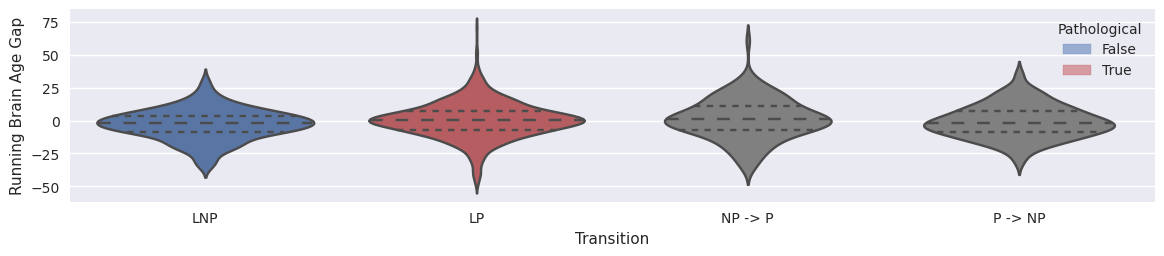

In [120]:
fig, ax = plt.subplots(1,1,figsize=(14,2.5))
ax = sns.violinplot(
    data=df, y='Gap diff', x='Transition', 
    inner='quartile', palette=['b', 'r', 'gray', 'gray'], ax=ax,
    order=['LNP', 'LP', 'NP -> P', 'P -> NP'],
)
ax.legend(title='Pathological', handles=patches, loc='best')
ax.set_ylabel('Running Brain Age Gap')
#ax.set_ylim(-300, 300)